In [1]:
# 安装 Pandas，用于数据分析和处理 (例如读取CSV, 处理表格数据)
!pip install pandas

# 安装 Matplotlib 和 Seaborn，用于数据可视化 (例如绘制图表)
!pip install matplotlib seaborn

In [ ]:
"""
数据处理: 合并所有年度的 MODIS 火点数据 (2010-2019)

MODIS数据不能直接用，它提供的不是“秸秆焚烧点”，而是“火点”，
原始的 modis_*.csv 文件中包含了所有类型的火灾：森林火灾、草原火灾、工业火点（如钢厂）、甚至可能是火山。
所以我们要设计一个分类器（Classifier），从这107万个“火点”中，筛选出那些最有可能是秸秆焚烧的火点。

根据项目要求和借鉴的论文，这个分类器至少需要三个规则：

规则1：数据质量过滤器（清洗）
一轮清洗，处理 acq_date 和 acq_time，并删除时间格式错误的数据。
进一步清洗，（根据论文）使用 confidence (置信度) 字段。MODIS数据中的confidence表示“这是一个真实火点的可信度”。
建议规则： 我们可以过滤掉低置信度的火点，例如，只保留 confidence >= 50% 的火点。这可以筛除大量“假火”或噪声。

规则2：空间过滤器（在哪里烧？）
规则： 秸秆焚烧必须发生在农田上。
执行： 当我们拿到火点（例如：经度125.5, 纬度46.5），我们会去查询这两个 .tif 文件。
如果这个坐标在 .tif 文件中没有数据（即 NoData ），我们就拒绝它，因为它不在玉米或小麦种植区内。

规则3：时间过滤器（什么时候烧？）
规则： 秸秆焚烧必须发生在收获期前后。
方法： 对于通过了“规则2”的火点，我们会从 .tif 文件中提取该像素的**“作物成熟日期（DOY）” 。
执行： 火灾是否在成熟期附近？我们要使用一个恰当的时间窗口，例如“收获期前15天和收获期后30天”。

我们的规则可以定为： 火灾的DOY必须在 [作物成熟DOY - 15天, 作物成熟DOY + 30天] 这个窗口内。

题目注意有不同要求：
Task1：Explore the seasonality and geographic distribution of all fire events.所有火灾事件

Task2：...based on their location relative to croplands and 
their timing relative to harvest seasons...只关注收获季节的农业燃烧
（早于这个窗口：可能是春耕的火（另一类农业火）
晚于这个窗口：可能是第二年的火，与本次收获无关。）

不在农田上：可能是森林火灾。

总结： 只有同时满足这三条规则的火点，才会被我们归类为“秸秆焚烧”。

我们先做数据处理的step 1，将2010年至2019年的MODIS数据合并整理，
然后根据confidence (置信度) 字段去除掉“噪声”或“假火”后，完成task1，
再接着完成task2、task3

In [2]:
"""
目标:
1. 自动在脚本所在目录查找所有 'modis_201*_China.csv' 文件。
2. 逐个加载文件，并对 'acq_date' 和 'acq_time' 列进行标准化处理。
   (v3: 明确指定日期时间格式 '%Y-%m-%d %H:%M')
   (v4: 使用 .apply(str).strip() 替换 .astype(str).str.strip() 
        来解决 'AttributeError: 'Series' object has no attribute 'str'')
3. 删除任何时间转换失败的无效数据行。
4. 将所有10个年度的数据表 (DataFrame) 合并为一个主表。
5. 将合并后的完整数据集保存为 'modis_2010_2019_processed.csv'。
"""

# ----------------------------------
# 1. 导入所需标准库
# ----------------------------------
import pandas as pd  # 用于数据处理
import glob          # 用于查找文件
import os            # 用于处理文件和目录路径

print("--- 数据处理step 1开始 ---")
print("--- 目标: 合并10个年度的MODIS CSV文件... ---")

# ----------------------------------
# 2. 确定文件路径
# ----------------------------------
try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIR = os.getcwd()
    print(f"警告: 无法检测 __file__。假定文件在当前工作目录: {SCRIPT_DIR}")

print(f"脚本将在以下目录中查找CSV文件: {SCRIPT_DIR}")

file_pattern = os.path.join(SCRIPT_DIR, "modis_201*_China.csv")
file_list = sorted(glob.glob(file_pattern))

if not file_list:
    print(f"错误：在目录 {SCRIPT_DIR} 中未找到任何 'modis_201*_China.csv' 文件。")
    print("请确保脚本与你的10个CSV文件放在同一个文件夹下。")
    exit()
else:
    print(f"成功找到 {len(file_list)} 个MODIS数据文件，准备合并。")

# ----------------------------------
# 3. 定义文件处理函数
# ----------------------------------
def process_modis_file(file_path):
    """
    加载并预处理单个MODIS CSV文件。
    """
    try:
        print(f"--- ------------------------------ ---")
        print(f"--- 正在处理: {os.path.basename(file_path)} ---")
        df = pd.read_csv(file_path)

        # 1. 日期和时间标准化
        # 我们使用 .apply() 来遍历每一行 (x)
        # str(x) 将单元格内容强制转为字符串
        # .strip() 清理该字符串的空格
        acq_date_cleaned = df['acq_date'].apply(lambda x: str(x).strip())
        
        # 将 'acq_time' 转换为 4位字符串 （例如：0242）
        acq_time_str = df['acq_time'].astype(str).str.zfill(4)
        # 转换为 HH:MM 格式 (例如 '02:42')
        acq_time_formatted = acq_time_str.str[:2] + ':' + acq_time_str.str[2:]
        
        # 合并日期和时间字符串 (例如 '2010-01-01 02:42')
        datetime_str = acq_date_cleaned + ' ' + acq_time_formatted
        
        # 2. 转换为 datetime 对象
        # 明确地告诉 pandas 我们的日期格式是 '年-月-日 时:分'
        df['datetime'] = pd.to_datetime(
            datetime_str, 
            format='%Y-%m-%d %H:%M', 
            errors='coerce'
        )
        
        # 3. 数据清洗: 移除 'datetime' 转换失败的行 (NaT)
        original_rows = len(df)
        df.dropna(subset=['datetime'], inplace=True)
        cleaned_rows = len(df)
        if original_rows > cleaned_rows:
            print(f"注意: 移除了 {original_rows - cleaned_rows} 条无效日期记录。")
        
        # 4. 提取 'year' 特征，用于后续统计
        df['year'] = df['datetime'].dt.year.astype(int)
        
        return df
        
    except FileNotFoundError:
        print(f"错误：pd.read_csv 无法读取文件 {file_path}。")
        return None
    except KeyError as e:
        print(f"错误：文件 {os.path.basename(file_path)} 缺少关键列 {e}。")
        return None
    except Exception as e:
        print(f"处理 {os.path.basename(file_path)} 时发生未知错误： {e}")
        return None

# ----------------------------------
# 4. 循环加载、处理并合并所有文件
# ----------------------------------
all_dataframes = [] 

for f_path in file_list:
    processed_df = process_modis_file(f_path)
    if processed_df is not None:
        all_dataframes.append(processed_df)

# ----------------------------------
# 5. 合并所有数据并保存
# ----------------------------------
if all_dataframes:
    df_modis_all = pd.concat(all_dataframes, ignore_index=True)
    
    print("\n" + "="*50)
    print("--- 所有年度数据合并完成 ---")
    print(f"总共合并了 {len(df_modis_all)} 条火灾记录。")
    
    # 打印每年的火点数量，作为核查
    print("\n--- 每年火点数量统计 ---")
    print(df_modis_all['year'].value_counts().sort_index())
    
    # ----------------------------------
    # 6. 保存到文件
    # ----------------------------------
    output_file_path = os.path.join(SCRIPT_DIR, "modis_2010_2019_processed.csv")
    
    try:
        df_modis_all.to_csv(output_file_path, index=False)
        print(f"\n成功！已将所有合并后的数据保存到: {output_file_path}")
    except Exception as e:
        print(f"错误：保存到 {output_file_path} 失败。 {e}")
else:
    print("\n错误：没有数据被处理或合并。")
    print("请检查 'process_modis_file' 函数中的错误信息。")

print("\n--- 数据处理step 1 结束 ---")

--- 数据处理step 1开始 ---
--- 目标: 合并10个年度的MODIS CSV文件... ---
警告: 无法检测 __file__。假定文件在当前工作目录: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交
脚本将在以下目录中查找CSV文件: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交
成功找到 10 个MODIS数据文件，准备合并。
--- ------------------------------ ---
--- 正在处理: modis_2010_China.csv ---
--- ------------------------------ ---
--- 正在处理: modis_2011_China.csv ---
--- ------------------------------ ---
--- 正在处理: modis_2012_China.csv ---
--- ------------------------------ ---
--- 正在处理: modis_2013_China.csv ---
--- ------------------------------ ---
--- 正在处理: modis_2014_China.csv ---
--- ------------------------------ ---
--- 正在处理: modis_2015_China.csv ---
--- ------------------------------ ---
--- 正在处理: modis_2016_China.csv ---
--- ------------------------------ ---
--- 正在处理: modis_2017_China.csv ---
--- --------------------------

--- 数据处理step 2 开始 ---
--- 目标: 分析 'confidence' (置信度) 列的分布情况... ---
警告: 无法检测 __file__。假定文件在当前工作目录: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交
正在加载 modis_2010_2019_processed.csv... (这可能需要几秒钟)
成功加载 1073119 条记录。

--- 'confidence' (置信度) 列的描述性统计 ---
count    1.073119e+06
mean     5.819978e+01
std      1.899731e+01
min      0.000000e+00
25%      4.600000e+01
50%      5.900000e+01
75%      7.100000e+01
max      1.000000e+02
Name: confidence, dtype: float64

--- 正在绘制 'confidence' 分布直方图... ---


findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: 


成功！已将分析图表保存到: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交\confidence_distribution.png

--- 数据处理step 2 结束 ---


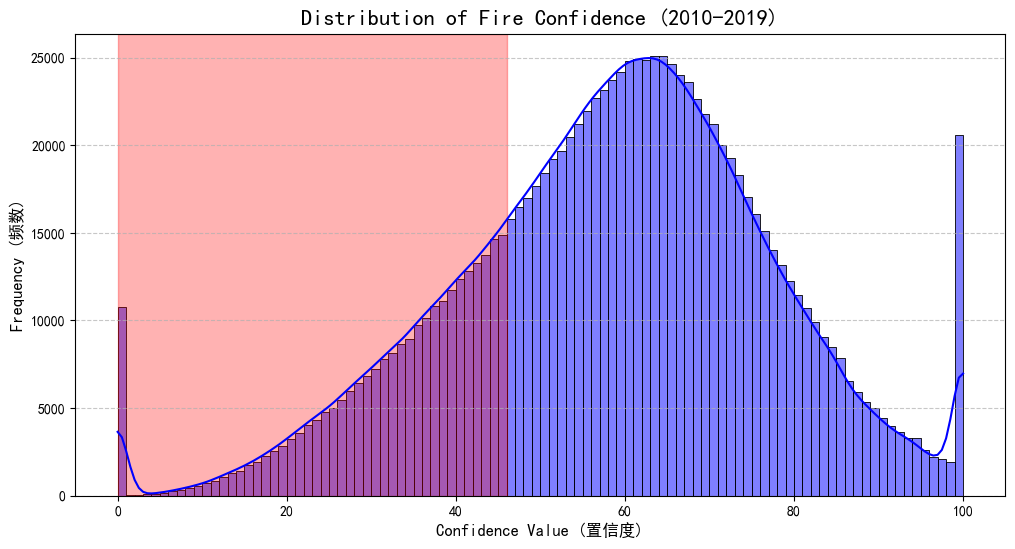

In [3]:
"""
数据处理step 2: 分析置信度 (confidence) 分布

目标:
1. 加载 数据处理step 1 生成的 'modis_2010_2019_processed.csv' 文件。
2. 分析 'confidence' 这一列的详细统计数据 (例如: 最小值, 最大值, 中位数等)。
3. 绘制 'confidence' 值的分布直方图 (Histogram)。
4. 将分析图表保存为 'confidence_distribution.png'。
"""

# ----------------------------------
# 1. 导入所需标准库
# ----------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("--- 数据处理step 2 开始 ---")
print("--- 目标: 分析 'confidence' (置信度) 列的分布情况... ---")

# ----------------------------------
# 2. 确定文件路径
# ----------------------------------
try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIR = os.getcwd()
    print(f"警告: 无法检测 __file__。假定文件在当前工作目录: {SCRIPT_DIR}")

# 这是 数据处理step 1 生成的文件
file_name = "modis_2010_2019_processed.csv"
file_path = os.path.join(SCRIPT_DIR, file_name)

if not os.path.exists(file_path):
    print(f"错误：未找到 {file_path}。")
    print("请先确保 数据处理step 1 已成功运行。")
    exit()

# ----------------------------------
# 3. 加载合并后的数据
# ----------------------------------
print(f"正在加载 {file_name}... (这可能需要几秒钟)")
try:
    df_all = pd.read_csv(file_path)
    
    # 检查 'confidence' 列是否存在
    if 'confidence' not in df_all.columns:
        print("错误：数据中未找到 'confidence' 列。")
        print("请检查CSV文件。")
        exit()
    
    # 将 'confidence' 列转换为数字，以防万一
    df_all['confidence'] = pd.to_numeric(df_all['confidence'], errors='coerce')
    # 移除 'confidence' 为空的行 (如果存在的话)
    df_all.dropna(subset=['confidence'], inplace=True) 
    
    print(f"成功加载 {len(df_all)} 条记录。")
    
except Exception as e:
    print(f"加载文件时发生错误: {e}")
    exit()

# ----------------------------------
# 4. 分析 'confidence' 的统计数据
# ----------------------------------
print("\n" + "="*50)
print("--- 'confidence' (置信度) 列的描述性统计 ---")
# .describe() 会给出计数、均值、标准差、最小值、
# 25%分位数、50%分位数(中位数)、75%分位数和最大值
# 我们特别关注 25%, 50% (中位数) 和 75% 的值
print(df_all['confidence'].describe())
print("="*50)

# ----------------------------------
# 5. 绘制 'confidence' 分布直方图
# ----------------------------------
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
print("\n--- 正在绘制 'confidence' 分布直方图... ---")
try:
    # 设置画布大小
    plt.figure(figsize=(12, 6))
    
    # 使用 seaborn 绘制直方图 (histogram)
    # bins=100 将 0-100 的范围切成 100 个柱子
    # kde=True 会额外绘制一条平滑的密度曲线
    sns.histplot(df_all['confidence'], bins=100, kde=True, color='blue')
    
    plt.title('Distribution of Fire Confidence (2010-2019)', fontsize=16)
    plt.xlabel('Confidence Value (置信度)', fontsize=12)
    plt.ylabel('Frequency (频数)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 在充分分析数据后，出于ppt的可视化目的，作图
    plt.axvspan(xmin=0, xmax=46, color='red', alpha=0.3, label='Confidence < 46% (25% of data)')
    
    # ----------------------------------
    # 6. 保存图表
    # ----------------------------------
    output_image = 'confidence_distribution.png'
    output_image_path = os.path.join(SCRIPT_DIR, output_image)
    
    plt.savefig(output_image_path)
    
    print(f"\n成功！已将分析图表保存到: {output_image_path}")

except Exception as e:
    print(f"\n错误：绘制或保存图表时失败。{e}")

print("\n--- 数据处理step 2 结束 ---")

In [ ]:
"""
解读：
25% = 46.0： 它意味着在107万条火点中，有整整 25% 的火点，其可信度低于 46%。
50% = 59.0： 中位数是 59%。一半的数据低于它，一半高于它。
Histogram ： 这张图展示了：在左侧（0-40的范围）有大量的“低置信度”火点，我们必须将它们过滤掉。

我们的规则： 我们将设定一个阈值，只保留 confidence >= 50 的火点。

为什么是 50？
这是一个非常标准、易于解释的阈值（“我们只保留中高置信度的火点”）。

根据统计数据，这个阈值 (>= 50) 会帮我们过滤掉超过 25% 的、质量最低的数据（因为 25% 分位数是 46）。
且它保留了大多数的数据：这个阈值会保留所有 confidence 在 50 到 100 之间的火点。
根据统计数据，这至少占了总数据的 50% 以上（因为 50% 中位数是 59）。
它在方法论上也最稳健： 它代表了一个清晰的立场——“我们只信任那些卫星团队认为‘中等可信’及以上的火点”

总之，50 是一个既能有效清除这部分垃圾，又能最大限度保留 50 以上（包括 50）的有效数据的、最平衡的阈值
"""

In [4]:
"""
数据处理step 3: 应用置信度过滤器并保存

目标:
1. 加载 数据处理step 1 生成的 'modis_2010_2019_processed.csv' 文件。
2. 定义一个置信度阈值 (FILTER_THRESHOLD = 50)。
3. 筛选数据，只保留 'confidence' >= 50 的火点。
4. 报告过滤前后的数据量对比。
5. 将最终清洗后的数据保存为 'modis_2010_2019_cleaned.csv'。
   这个 "cleaned" (已清洗) 文件将是我们后续所有分析的基础。
"""

# ----------------------------------
# 1. 导入所需标准库
# ----------------------------------
import pandas as pd
import os

print("--- 数据处理step 3 开始 ---")
print("--- 目标: 应用 'confidence' 过滤器 (规则1) 清洗数据... ---")

# ----------------------------------
# 2. 定义我们的清洗规则
# ----------------------------------
# 基于 数据处理step 2 的分析 (25%分位数=46)，我们设定 50% 作为阈值。
# 这将移除所有低置信度的火点。
FILTER_THRESHOLD = 50 
print(f"--- 清洗规则: 将只保留 confidence >= {FILTER_THRESHOLD} 的火点 ---")

# ----------------------------------
# 3. 确定文件路径
# ----------------------------------
try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIR = os.getcwd()
    print(f"警告: 无法检测 __file__。假定文件在当前工作目录: {SCRIPT_DIR}")

# 这是 数据处理step 1 生成的文件
file_name = "modis_2010_2019_processed.csv"
file_path = os.path.join(SCRIPT_DIR, file_name)

# 这是我们将要创建的 "已清洗" 文件
output_file = "modis_2010_2019_cleaned.csv"
output_file_path = os.path.join(SCRIPT_DIR, output_file)

if not os.path.exists(file_path):
    print(f"错误：未找到 {file_path}。")
    print("请先确保 数据处理step 1 已成功运行。")
    exit()

# ----------------------------------
# 4. 加载合并后的数据
# ----------------------------------
print(f"正在加载 {file_name}...")
try:
    df_all = pd.read_csv(file_path)
    
    # 确保 'confidence' 列存在且为数字
    if 'confidence' not in df_all.columns:
        print("错误：数据中未找到 'confidence' 列。")
        exit()
    df_all['confidence'] = pd.to_numeric(df_all['confidence'], errors='coerce')
    df_all.dropna(subset=['confidence'], inplace=True) 
    
except Exception as e:
    print(f"加载文件时发生错误: {e}")
    exit()

# ----------------------------------
# 5. 应用过滤器
# ----------------------------------
total_count_before = len(df_all)
print(f"过滤前总火点数: {total_count_before}")

# 执行过滤
# 我们只选择 'confidence' 列大于或等于 FILTER_THRESHOLD 的行
df_cleaned = df_all[df_all['confidence'] >= FILTER_THRESHOLD].copy()

total_count_after = len(df_cleaned)
print(f"过滤后剩余火点数: {total_count_after}")

# 计算被移除的百分比
percentage_removed = ( (total_count_before - total_count_after) / total_count_before ) * 100
print(f"成功移除了 {total_count_before - total_count_after} 条低置信度火点 ({percentage_removed:.2f}%)。")

# ----------------------------------
# 6. 保存最终的清洁数据
# ----------------------------------
if total_count_after > 0:
    try:
        # 我们只保存后续分析真正需要的列
        # (保留了 'type' 和 'frp' 以备 Task 4 使用)
        columns_to_save = [
            'latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date', 
            'acq_time', 'satellite', 'instrument', 'confidence', 'version', 
            'bright_t31', 'frp', 'daynight', 'type', 'datetime', 'year'
        ]
        
        # 为了更稳健，我们只保留 df_cleaned 中实际存在的列
        existing_columns = [col for col in columns_to_save if col in df_cleaned.columns]
        
        # 提取 'month', 'week', 'doy' 以便 Task 1 使用
        df_cleaned['datetime'] = pd.to_datetime(df_cleaned['datetime'])
        df_cleaned['month'] = df_cleaned['datetime'].dt.month
        df_cleaned['week'] = df_cleaned['datetime'].dt.isocalendar().week
        df_cleaned['doy'] = df_cleaned['datetime'].dt.dayofyear
        
        # 将 'month', 'week', 'doy' 添加到要保存的列列表中
        existing_columns.extend(['month', 'week', 'doy'])
        
        df_cleaned[existing_columns].to_csv(output_file_path, index=False)
        print(f"\n成功！已将【已清洗】的数据保存到: {output_file_path}")
    except Exception as e:
        print(f"错误：保存到 {output_file_path} 失败。 {e}")
else:
    print("错误: 过滤后没有数据被保留，请检查你的阈值。")

print("\n--- 数据处理step 3 结束 ---")

--- 数据处理step 3 开始 ---
--- 目标: 应用 'confidence' 过滤器 (规则1) 清洗数据... ---
--- 清洗规则: 将只保留 confidence >= 50 的火点 ---
警告: 无法检测 __file__。假定文件在当前工作目录: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交
正在加载 modis_2010_2019_processed.csv...
过滤前总火点数: 1073119
过滤后剩余火点数: 751014
成功移除了 322105 条低置信度火点 (30.02%)。

成功！已将【已清洗】的数据保存到: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交\modis_2010_2019_cleaned.csv

--- 数据处理step 3 结束 ---


In [5]:
"""
Task 1 分析时空模式

目标:
1. 加载 处理step 3 生成的 'modis_2010_2019_cleaned.csv' (已清洗) 文件。
2. (Task 1 - 月度图) 绘制正确的、基于火点数量渐变的柱状图。
3. (Task 1 - 周度图) 绘制带滚动平均线、自动标注峰值的专业折线图。
4. (Task 1 - 空间图) 绘制长宽比例正确的空间热力图。
"""

# ----------------------------------
# 1. 导入所需标准库
# ----------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # 导入颜色库
import matplotlib.cm as cm          # 导入 colormap 库
import seaborn as sns
import os

# 设置 Seaborn 的全局样式，使图表更美观
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100 # 提高图表分辨率

print("--- Task 1 开始 ---")
print("--- 目标: 生成时空分析图表... ---")

# ----------------------------------
# 2. 确定文件路径
# ----------------------------------
try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIR = os.getcwd()
    print(f"警告: 无法检测 __file__。假定文件在当前工作目录: {SCRIPT_DIR}")

file_name = "modis_2010_2019_cleaned.csv"
file_path = os.path.join(SCRIPT_DIR, file_name)

if not os.path.exists(file_path):
    print(f"错误：未找到 {file_path}。")
    print("请先确保 处理step 3 已成功运行。")
    exit()

# ----------------------------------
# 3. 加载【已清洗】的数据
# ----------------------------------
print(f"正在加载 {file_name}...")
try:
    df_clean = pd.read_csv(file_path)
    df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])
    print(f"成功加载 {len(df_clean)} 条【已清洗】的记录。")
except Exception as e:
    print(f"加载 {file_name} 时发生错误： {e}")
    exit()

num_years = df_clean['year'].nunique()
if num_years == 0:
    print("错误: 数据中没有年份信息。")
    exit()
print(f"数据覆盖 {num_years} 年。")

# ----------------------------------
# 4. (Task 1) 绘制10年平均时空模式
# ----------------------------------
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
print("--- (Task 1) 正在绘制月度图... ---")

# --- Task 1a. 10年平均月度模式  ---
try:
    monthly_total_counts = df_clean.groupby('month').size().reset_index(name='total_fire_count')
    monthly_total_counts['avg_fire_count'] = monthly_total_counts['total_fire_count'] / num_years
    
    # 我们根据 'avg_fire_count' 的值来创建颜色，便于满足生成图片更具可视化
    norm = mcolors.Normalize(vmin=monthly_total_counts['avg_fire_count'].min(), 
                             vmax=monthly_total_counts['avg_fire_count'].max())
    # 使用 YlOrRd (黄-橙-红) 颜色表
    cmap = cm.get_cmap('YlOrRd')
    # 为12个柱子生成对应的颜色列表
    bar_colors = cmap(norm(monthly_total_counts['avg_fire_count']))

    # --- 开始绘图 ---
    fig, ax = plt.subplots(figsize=(12, 7))
    
    #  使用 plt.bar 并传入颜色
    bars = plt.bar(
        monthly_total_counts['month'],
        monthly_total_counts['avg_fire_count'],
        color=bar_colors # <-- 在这里应用我们计算好的颜色
    )
    
    # 添加颜色条 (Colorbar)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) # 必须设置一个空数组
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Average Fire Counts (火点数)', rotation=270, labelpad=15)
    
    # 在每个柱子顶部添加数据标签
    ax.bar_label(bars, fmt='%.0f', padding=3)
    
    ax.set_title(f'10-Year Average Monthly Fire Counts (Color-coded by Value)', fontsize=16)
    ax.set_xlabel('Month (月份)', fontsize=12)
    ax.set_ylabel('Average Fire Counts (年平均火点数)', fontsize=12)
    # X轴刻度必须手动设置为 1-12
    ax.set_xticks(monthly_total_counts['month'])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    # 移除顶部和右侧的边框
    sns.despine() 
    
    plt.tight_layout()
    output_png = os.path.join(SCRIPT_DIR, 'task1_monthly_fire_counts_avg.png')
    plt.savefig(output_png)
    print(f"成功保存图表: {output_png}")
    plt.close(fig)

except Exception as e:
    print(f"错误：绘制【月度图】时失败。{e}")

# --- Task 1b. 10年平均周度模式  ---
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
print("--- (Task 1) 正在绘制周度图... ---")
try:
    weekly_total_counts = df_clean.groupby('week').size().reset_index(name='total_fire_count')
    weekly_total_counts['avg_fire_count'] = weekly_total_counts['total_fire_count'] / num_years
    
    # 计算4周滚动平均值
    weekly_total_counts['rolling_avg_4w'] = weekly_total_counts['avg_fire_count'].rolling(window=4, center=True, min_periods=1).mean()

    # 找出峰值周
    spring_data = weekly_total_counts[weekly_total_counts['week'] < 30]
    peak_spring_week = spring_data.loc[spring_data['rolling_avg_4w'].idxmax()]
    autumn_data = weekly_total_counts[weekly_total_counts['week'] > 30]
    peak_autumn_week = autumn_data.loc[autumn_data['rolling_avg_4w'].idxmax()]

    fig, ax = plt.subplots(figsize=(16, 7))
    
    # 绘制原始的周度平均值 (灰色, 半透明)
    sns.lineplot(data=weekly_total_counts, x='week', y='avg_fire_count', color='grey', alpha=0.4, label='Weekly Average (Raw)', ax=ax)
    
    # 绘制平滑的滚动平均线 (红色, 粗)
    sns.lineplot(data=weekly_total_counts, x='week', y='rolling_avg_4w', color='red', linewidth=2.5, label='4-Week Rolling Average (Smoothed Trend)', ax=ax)
    
    # 标注峰值
    ax.axvline(peak_spring_week['week'], color='blue', linestyle='--', alpha=0.7)
    ax.text(peak_spring_week['week'] + 1, peak_spring_week['rolling_avg_4w'], 
            f"Spring Peak (Week {peak_spring_week['week']:.0f})", color='blue')
    ax.axvline(peak_autumn_week['week'], color='darkred', linestyle='--', alpha=0.7)
    ax.text(peak_autumn_week['week'] - 1, peak_autumn_week['rolling_avg_4w'], 
            f"Autumn Peak (Week {peak_autumn_week['week']:.0f})", color='darkred', ha='right')

    ax.set_title('Smoothed Weekly Fire Seasonality (10-Year Average)', fontsize=16)
    ax.set_xlabel('Week of Year (年份中的周)', fontsize=12)
    ax.set_ylabel('Average Fire Counts (年平均火点数)', fontsize=12)
    ax.set_xticks(ticks=range(0, 54, 2))
    ax.legend()
    sns.despine()
    
    plt.tight_layout()
    output_png = os.path.join(SCRIPT_DIR, 'task1_weekly_fire_counts_avg.png')
    plt.savefig(output_png)
    print(f"成功保存图表: {output_png}")
    plt.close(fig)

except Exception as e:
    print(f"错误：绘制【周度图】时失败。{e}")


# --- Task 1c. 10年空间模式 (热力图)  ---
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
print("--- (Task 1) 正在绘制空间热力图... ---")
try:
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # 我们添加 norm=mcolors.LogNorm()
    # 这会告诉 hist2d 在上色前，先对火点计数取对数
    h = ax.hist2d(
        df_clean['longitude'], 
        df_clean['latitude'], 
        bins=200, 
        cmap='YlOrRd', 
        cmin=1,
        norm=mcolors.LogNorm() # <-- 应用对数标尺
    )
    
    # 添加颜色条
    fig.colorbar(h[3], ax=ax, label='Fire Counts (Log Scale)', shrink=0.75)
    
    # 保持长宽比为 'equal'
    ax.set_aspect('equal')
    
    ax.set_title('Spatial Distribution of Fire Hotspots (2010-2019, Log Scale)', fontsize=16)
    ax.set_xlabel('Longitude (经度)', fontsize=12)
    ax.set_ylabel('Latitude (纬度)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    fig.tight_layout()
    output_png = os.path.join(SCRIPT_DIR, 'task1_spatial_fire_heatmap_10yr.png')
    plt.savefig(output_png, dpi=300)
    print(f"成功保存图表: {output_png}")
    plt.close(fig)
    
except Exception as e:
    print(f"错误：绘制【空间热力图】时失败。{e}")

print("\n--- step 4 (Task 1) 结束 ---")

--- Task 1 开始 ---
--- 目标: 生成时空分析图表... ---
警告: 无法检测 __file__。假定文件在当前工作目录: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交
正在加载 modis_2010_2019_cleaned.csv...


C:\Users\46400\AppData\Local\Temp\ipykernel_30804\2563370729.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('YlOrRd')
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti T

成功加载 751014 条【已清洗】的记录。
数据覆盖 10 年。
--- (Task 1) 正在绘制月度图... ---


findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: 

成功保存图表: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交\task1_monthly_fire_counts_avg.png
--- (Task 1) 正在绘制周度图... ---


findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: 

成功保存图表: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交\task1_weekly_fire_counts_avg.png
--- (Task 1) 正在绘制空间热力图... ---


findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: 

成功保存图表: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交\task1_spatial_fire_heatmap_10yr.png

--- step 4 (Task 1) 结束 ---


In [ ]:

"""
===================================================================
TASK 1: ANALYSIS SUMMARY
===================================================================

Based on the analysis of 751,014 high-confidence (confidence >= 50) 
fire hotspots from 2010-2019, fire activity in China exhibits 
highly concentrated spatiotemporal patterns.

*** Seasonality

Fire activity presents a distinct bimodal pattern, with two 
independent peak periods each year, occurring in spring and 
autumn respectively.
- Spring Peak: As shown in the monthly chart, March is the month with the highest fire activity,
followed by April and February.
- Autumn Peak: October is the second major peak period.
- Low Season: The summer months, particularly July and August, 
represent the period of least fire activity.

This bimodal pattern strongly suggests that fire activity is highly correlated with China's agricultural cycles:
1.The Spring Peak corresponds to land preparation activities before spring planting (spring plowing and burning).
2.The Autumn Peak corresponds to post-harvest activities (autumn stubble burning).

（Figure 1: 10-Year Average Monthly Fire Distribution. This chart displays two clear peaks (March and October) 
and is color-coded by fire count (Red=High, Yellow=Low).）

***Hotspot Weeks & Intra-seasonal Patterns

The monthly chart masks the explosive speed of fire activity. The weekly chart provides us with a more granular 
intra-seasonal pattern:
- Smoothed Trend: The red smoothed line (4-week rolling average) clearly delineates the "true trend" of the two 
peaks, removing the raw weekly "noise" (thin gray line).
- Spring Hotspot Week: Spring fire activity peaks around Week 12 (late March) before declining rapidly.
- Autumn Hotspot Week: Autumn fire activity peaks around Week 42 (mid-to-late October).

This chart confirms the requirement of Task 1: fires are not uniformly distributed across several months but are 
concentrated in specific "hotspot weeks".

（Figure 2: Smoothed Weekly Fire Seasonality (with Peak Annotations). This chart identifies Week 12 as the 
spring peak and Week 42 as the autumn peak via the rolling average (red line).）

***Geographic Distribution
The spatial heatmap clearly shows that fire activity in China is extremely uneven geographically.
- Absolute Hotspot Zone: The vast majority of fires (the darkest colored areas) are overwhelmingly concentrated 
in Northeast China, specifically in the Songnen Plain and Sanjiang Plain where Heilongjiang and Jilin provinces are located.
- Secondary Hotspot Zone: The North China Plain (Shandong, Henan, Hebei, etc.) also shows significant fire hotspots, but its 
density and extent are far less than in the Northeast.
- Conclusion: The spatial patterns are consistent with the temporal analysis. As Northeast China is the most important 
commercial grain base (corn, rice), the high spatial concentration of fires further corroborates the hypothesis that these 
fires originate primarily from agricultural activities.

（Figure 3: 10-Year Fire Hotspot Spatial Distribution Heatmap. This map shows that fire hotspots are overwhelmingly 
concentrated in the main agricultural regions of Northeast China.）

In [6]:
# 安装用于处理【矢量】地理数据的库
!pip install geopandas
# 安装用于处理【栅格】地理数据的库
!pip install rasterio

"""
task 2（1）: 检查 CHN_County.shp 的结构

目标:
1. 加载 'geopandas' 库。
2. 读取 'CHN_County.shp' 文件。
3. 打印出该地图的 "坐标参考系 (CRS)"。
4. 打印出该地图数据表的前 5 行 (head)，以便我们查看
   所有列的名称 (例如 'NAME_1', 'NAME_2' 等)。
"""

# ----------------------------------
# 1. 导入所需标准库
# ----------------------------------
import pandas as pd # 我们仍然需要 pandas
import geopandas as gpd # 导入我们新安装的 geopandas
import os

print("--- task 2（1） 开始 ---")
print("--- 目标: 检查 'CHN_County.shp' 的文件结构... ---")

# ----------------------------------
# 2. 确定文件路径
# ----------------------------------
try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIR = os.getcwd()
    print(f"警告: 无法检测 __file__。假定文件在当前工作目录: {SCRIPT_DIR}")

# 这是你上传的 Shapefile 文件
file_name = "CHN_County.shp"
file_path = os.path.join(SCRIPT_DIR, file_name)

if not os.path.exists(file_path):
    print(f"错误：未找到 {file_path}。")
    print("请确保 task 2（1） 与你的 CHN_County.shp 等文件在同一文件夹中。")
    exit()

# ----------------------------------
# 3. 加载并检查 Shapefile
# ----------------------------------
try:
    print(f"正在加载 {file_name}...")
    
    # 使用 geopandas 读取 .shp 文件
    gdf_counties = gpd.read_file(file_path)
    
    print("\n" + "="*50)
    print("--- 1. Shapefile 坐标参考系 (CRS) ---")
    print(gdf_counties.crs)
    print("="*50)
    
    print("\n" + "="*50)
    print("--- 2. Shapefile 数据表列名和前5行数据 ---")
    # 打印前 5 行，以便我们看到列名和示例数据
    print(gdf_counties.head())
    print("="*50)
    
    print(f"\n成功加载并检查了 {len(gdf_counties)} 个县级多边形。")

except ImportError:
    print("\n\n" + "*"*50)
    print("错误：'geopandas' 库未找到。")
    print("你似乎跳过了 第5步(A) 的安装步骤。")
    print("请先在你的 'Anaconda Prompt' 中运行: conda install geopandas -c conda-forge")
    print("然后再重新运行此脚本。")
    print("*"*50)
except Exception as e:
    print(f"\n错误：加载 Shapefile 时失败。{e}")

print("\n--- task 2（1） 结束 ---")

--- task 2（1） 开始 ---
--- 目标: 检查 'CHN_County.shp' 的文件结构... ---
警告: 无法检测 __file__。假定文件在当前工作目录: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交
正在加载 CHN_County.shp...

--- 1. Shapefile 坐标参考系 (CRS) ---
EPSG:4326

--- 2. Shapefile 数据表列名和前5行数据 ---
     地名       区划码    县级       县级码  县级类           地级       地级码  地级类        省级  \
0  阿巴嘎旗  152522.0  阿巴嘎旗  152522.0    旗        锡林郭勒盟  152500.0    盟    内蒙古自治区   
1   阿坝县  513231.0   阿坝县  513231.0    县    阿坝藏族羌族自治州  513200.0  自治州       四川省   
2   阿城区  230112.0   阿城区  230112.0  市辖区         哈尔滨市  230100.0  地级市      黑龙江省   
3  阿尔山市  152202.0  阿尔山市  152202.0  县级市          兴安盟  152200.0    盟    内蒙古自治区   
4  阿合奇县  653023.0  阿合奇县  653023.0    县  克孜勒苏柯尔克孜自治州  653000.0  自治州  新疆维吾尔自治区   

        省级码  ...            NAME_2 VAR_NAME2     GID_2 TYPE_2        NAME_1  \
0  150000.0  ...        Xilinguole      None  152500.0   None     Neimenggu   
1  510000.0  ...  Abazangzuqiangzu      Non

In [7]:

"""
task 2（2）: 空间连接 (Spatial Join)

目标:
1. 使用 'if...else' 逻辑结构
2. 加载 'modis_2010_2019_cleaned.csv' (75万火点)。
3. 加载 'CHN_County.shp' (中国地图) 并筛选黑龙江省。
4. 执行 "空间连接"，将火点与黑龙江的县级地图进行匹配 (使用 'predicate')。
5. 将匹配上的 (即位于黑龙江省内的) 火点保存到一个新文件。
"""

# ----------------------------------
# 1. 导入所需标准库
# ----------------------------------
import pandas as pd
import geopandas as gpd
import os
import time # 导入时间库，用于计时

print("--- task 2（2） 开始 ---")
print("--- 目标: 筛选黑龙江省火点并匹配到县... ---")

# ----------------------------------
# 2. 确定文件路径
# ----------------------------------
# os.getcwd() 在 Notebook 中会获取 .ipynb 文件所在的目录
SCRIPT_DIR = os.getcwd() 
print(f"假定文件在当前工作目录: {SCRIPT_DIR}")

# 输入文件
fires_csv_path = os.path.join(SCRIPT_DIR, "modis_2010_2019_cleaned.csv")
counties_shp_path = os.path.join(SCRIPT_DIR, "CHN_County.shp")
# 输出文件
output_csv_path = os.path.join(SCRIPT_DIR, "modis_heilongjiang_fires_with_county.csv")

# ----------------------------------
# 3. 加载火点数据 (CSV)
# ----------------------------------
df_fires = None # 先创建一个空变量
print(f"正在加载 {os.path.basename(fires_csv_path)}...")
try:
    df_fires = pd.read_csv(fires_csv_path)
    print(f"成功加载 {len(df_fires)} 条高质量火点。")
except Exception as e:
    print(f"错误：加载火点CSV时失败。{e}")

# ----------------------------------
# 4. 加载地图数据 (SHP)
# ----------------------------------
gdf_heilongjiang = None # 先创建一个空变量
# **关键逻辑**: 只有在 df_fires 成功加载后 (不为 None)，才继续执行
if df_fires is not None:
    print(f"正在加载 {os.path.basename(counties_shp_path)}...")
    try:
        gdf_counties = gpd.read_file(counties_shp_path)
        print(f"成功加载 {len(gdf_counties)} 个县级多边形。")
        
        # 根据 task 2（1） 的结果，筛选黑龙江省
        gdf_heilongjiang = gdf_counties[gdf_counties['省级'] == '黑龙江省'].copy()
        
        if len(gdf_heilongjiang) == 0:
            print("错误：在 '省级' 列中未找到 '黑龙江省'。请检查列名或值是否正确。")
        else:
            print(f"成功从地图中筛选出 {len(gdf_heilongjiang)} 个黑龙江省的县/区。")
            
    except Exception as e:
        print(f"错误：加载 Shapefile 或筛选时失败。{e}")
else:
    print("由于加载火点数据失败，已跳过加载地图。")


# ----------------------------------
# 5. 执行空间连接 (Spatial Join)
# ----------------------------------
# **关键逻辑**: 只有在火点 (df_fires) 和 地图 (gdf_heilongjiang) 都成功加载后才执行
if df_fires is not None and gdf_heilongjiang is not None:
    print("\n--- 正在执行空间连接... (这可能需要1-2分钟) ---")
    start_time = time.time() # 开始计时
    
    try:
        # 1. 将火点 (df_fires) 转换为 GeoDataFrame
        gdf_fires = gpd.GeoDataFrame(
            df_fires, 
            geometry=gpd.points_from_xy(df_fires.longitude, df_fires.latitude),
            crs="EPSG:4326" 
        )

        # 2. 执行空间连接 (使用 'predicate')
        gdf_fires_in_hlj = gpd.sjoin(
            gdf_fires, 
            gdf_heilongjiang, 
            how="inner", 
            predicate="within" 
        )

        end_time = time.time() # 结束计时
        print(f"--- 空间连接完成！耗时 {end_time - start_time:.2f} 秒 ---")

        # ----------------------------------
        # 6. 报告和保存结果
        # ----------------------------------
        if len(gdf_fires_in_hlj) > 0:
            print(f"\n成功！在 {len(df_fires)} 个总火点中，")
            print(f"有 {len(gdf_fires_in_hlj)} 个火点位于黑龙江省境内。")
            
            # 丢弃 'index_right' 列 (这是 sjoin 自动生成的)
            if 'index_right' in gdf_fires_in_hlj.columns:
                gdf_fires_in_hlj = gdf_fires_in_hlj.drop(columns=['index_right'])
            
            # 将结果保存为 CSV
            try:
                gdf_fires_in_hlj.to_csv(output_csv_path, index=False)
                print(f"\n成功！已将所有黑龙江省的火点数据保存到: {output_csv_path}")
                
                # 打印出匹配上的县的名称，作为检查
                print("\n--- 匹配上的县 (前50个唯一值) ---")
                print(gdf_fires_in_hlj['县级'].unique()[:50])
                
            except Exception as e:
                print(f"错误：保存CSV文件时失败。{e}")

        else:
            print("错误：空间连接未找到任何匹配的火点。")
            print("请检查火点CSV和Shapefile的CRS是否一致。")

    except Exception as e:
        print(f"错误：在空间连接或保存步骤中失败。{e}")
        
else:
    print("\n错误：由于之前的加载步骤失败，未执行空间连接。")

print("\n--- task 2（2） 结束 ---")

--- task 2（2） 开始 ---
--- 目标: 筛选黑龙江省火点并匹配到县... ---
假定文件在当前工作目录: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交
正在加载 modis_2010_2019_cleaned.csv...
成功加载 751014 条高质量火点。
正在加载 CHN_County.shp...
成功加载 2860 个县级多边形。
成功从地图中筛选出 128 个黑龙江省的县/区。

--- 正在执行空间连接... (这可能需要1-2分钟) ---
--- 空间连接完成！耗时 0.62 秒 ---

成功！在 751014 个总火点中，
有 135512 个火点位于黑龙江省境内。

成功！已将所有黑龙江省的火点数据保存到: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交\modis_heilongjiang_fires_with_county.csv

--- 匹配上的县 (前50个唯一值) ---
['杜尔伯特蒙古族自治县' '泰来县' '肇源县' '红岗区' '龙江县' '肇州县' '碾子山区' '讷河市' '北林区' '海林市' '宁安市'
 '五常市' '大同区' '尚志市' '道里区' '勃利县' '肇东市' '兰西县' '克东县' '克山县' '向阳区' '汤原县' '桦南县'
 '宝清县' '甘南县' '梅里斯达斡尔族区' '爱辉区' '昂昂溪区' '林甸县' '依安县' '富裕县' '通河县' '让胡路区' '新兴区'
 '富拉尔基区' '同江市' '集贤县' '富锦市' '友谊县' '尖山区' '依兰县' '茄子河区' '桦川县' '绥棱县' '庆安县'
 '海伦市' '嫩江市' '逊克县' '安达市' '双城区']

--- task 2（2） 结束 ---


In [8]:

"""
task 2（3）: 火灾分类

目标:
1. 加载 task 2（2） 生成的 'modis_heilongjiang_fires_with_county.csv'。
2. 确保 'year' 和 'doy' 列存在，如果不存在则从 'datetime' 列重新创建。
3. 定义分类规则。
4. 逐一处理每个火点，应用规则进行分类。
5. 将包含新 'fire_type' 列的数据保存为 'modis_heilongjiang_classified_fires.csv'。
6. 打印出每种火灾类型的数量统计。
"""

# ----------------------------------
# 1. 导入所需标准库
# ----------------------------------
import pandas as pd
import geopandas as gpd
import rasterio
import numpy as np
import os
import time

print("--- task 2（3） 开始 ---")
print("--- 目标: 对黑龙江省火点进行分类... ---")

# ----------------------------------
# 2. 定义分类规则和文件路径
# ----------------------------------
WINDOW_BEFORE = 15 # 成熟期前 15 天
WINDOW_AFTER = 30  # 成熟期后 30 天

try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIR = os.getcwd()
    print(f"警告: 无法检测 __file__。假定文件在当前工作目录: {SCRIPT_DIR}")

fires_hlj_path = os.path.join(SCRIPT_DIR, "modis_heilongjiang_fires_with_county.csv")
output_csv_path = os.path.join(SCRIPT_DIR, "modis_heilongjiang_classified_fires.csv")
tif_dir = SCRIPT_DIR 

# ----------------------------------
# 3. 加载黑龙江省火点数据
# ----------------------------------
gdf_fires_hlj = None # 初始化
print(f"正在加载 {os.path.basename(fires_hlj_path)}...")
try:
    df_fires_hlj = pd.read_csv(fires_hlj_path)
    
    #  确保 'datetime' 列是 datetime 对象
    if 'datetime' not in df_fires_hlj.columns:
        print("错误: 加载的数据中缺少 'datetime' 列。")
        exit()
    df_fires_hlj['datetime'] = pd.to_datetime(df_fires_hlj['datetime'])

    #  检查并重新创建 'year' 和 'doy' 列
    if 'year' not in df_fires_hlj.columns:
        print("警告: 数据中缺少 'year' 列，正在从 'datetime' 重新创建...")
        df_fires_hlj['year'] = df_fires_hlj['datetime'].dt.year
    if 'doy' not in df_fires_hlj.columns:
        print("警告: 数据中缺少 'doy' 列，正在从 'datetime' 重新创建...")
        df_fires_hlj['doy'] = df_fires_hlj['datetime'].dt.dayofyear
        
    #  确保 'geometry' 列被正确加载
    if 'geometry' not in df_fires_hlj.columns:
        print("错误: 加载的数据中缺少 'geometry' 列。")
        exit()
    gdf_fires_hlj = gpd.GeoDataFrame(
        df_fires_hlj, 
        geometry=gpd.GeoSeries.from_wkt(df_fires_hlj['geometry']),
        crs="EPSG:4326"
    )
    print(f"成功加载并准备了 {len(gdf_fires_hlj)} 条黑龙江省火点。")

except ImportError:
     print("\n错误：'rasterio' 库未找到。请先安装: pip install rasterio")
     exit()
except Exception as e:
    print(f"错误：加载黑龙江火点CSV或准备数据时失败。{e}")
    exit()

# ----------------------------------
# 4. 定义分类函数 (保持不变)
# ----------------------------------
def classify_fire(row):
    """根据火点位置和时间，以及对应的 TIF 文件，对火点进行分类。"""
    fire_year = row['year'] # 现在可以安全访问 'year'
    fire_doy = row['doy']   # 现在可以安全访问 'doy'
    fire_geom = row['geometry']
    
    maize_tif_path = os.path.join(tif_dir, f"Heilongjiang_Maize_MA_{fire_year}.tif")
    wheat_tif_path = os.path.join(tif_dir, f"Heilongjiang_Wheat_MA_{fire_year}.tif")
    
    maize_doy = np.nan
    wheat_doy = np.nan
    
    # --- 提取 Maize DOY ---
    if os.path.exists(maize_tif_path):
        try:
            with rasterio.open(maize_tif_path) as src:
                coords = [(fire_geom.x, fire_geom.y)]
                # 使用 indexes=1 指定只读取第一个波段
                value = next(src.sample(coords, indexes=1))[0] 
                nodata_value = src.nodata if src.nodata is not None else -9999
                # 增加检查，确保 value 不是空的或 None
                if value is not None and value != nodata_value and not np.isnan(value) and value > 0: 
                    maize_doy = value
        except Exception: pass
            
    # --- 提取 Wheat DOY ---
    if os.path.exists(wheat_tif_path):
        try:
            with rasterio.open(wheat_tif_path) as src:
                coords = [(fire_geom.x, fire_geom.y)]
                value = next(src.sample(coords, indexes=1))[0]
                nodata_value = src.nodata if src.nodata is not None else -9999
                if value is not None and value != nodata_value and not np.isnan(value) and value > 0:
                    wheat_doy = value
        except Exception: pass

    # --- 应用分类规则 ---
    is_on_cropland = not (np.isnan(maize_doy) and np.isnan(wheat_doy))
    
    if not is_on_cropland:
        return "Non_Cropland_Fire"
    else:
        if not np.isnan(maize_doy):
            if (maize_doy - WINDOW_BEFORE) <= fire_doy <= (maize_doy + WINDOW_AFTER):
                return "Maize_Straw_Burning"
        if not np.isnan(wheat_doy):
             if (wheat_doy - WINDOW_BEFORE) <= fire_doy <= (wheat_doy + WINDOW_AFTER):
                return "Wheat_Straw_Burning"
        return "Cropland_Fire_Other"

# ----------------------------------
# 5. 应用分类函数到所有火点
# ----------------------------------
# 这是一个非常耗时的步骤，可能需要 5-15 分钟！
# **关键逻辑**: 只有在 gdf_fires_hlj 成功创建后才执行
if gdf_fires_hlj is not None:
    print("\n--- 正在对所有火点进行分类... (这可能需要 5-15 分钟) ---")
    start_time = time.time()

    try:
        # 使用 .apply() 方法将 classify_fire 函数应用到 DataFrame 的每一行 (axis=1)
        gdf_fires_hlj['fire_type'] = gdf_fires_hlj.apply(classify_fire, axis=1)

        end_time = time.time()
        print(f"--- 分类完成！耗时 {end_time - start_time:.2f} 秒 ---")

        # ----------------------------------
        # 6. 报告和保存结果
        # ----------------------------------
        print("\n" + "="*50)
        print("--- 火灾分类结果统计 ---")
        print(gdf_fires_hlj['fire_type'].value_counts())
        print("="*50)

        # 保存包含 'fire_type' 列的结果
        try:
            gdf_fires_hlj.to_csv(output_csv_path, index=False)
            print(f"\n成功！已将分类后的火点数据保存到: {output_csv_path}")
        except Exception as e:
            print(f"错误：保存分类结果CSV文件时失败。{e}")
            
    except Exception as e:
        print(f"错误：在应用分类函数时失败。{e}")
        # 打印更详细的错误回溯信息，帮助调试
        import traceback
        traceback.print_exc()

else:
    print("\n错误：由于加载或准备数据失败，未执行分类。")


print("\n--- task 2（3） 结束 ---")

--- task 2（3） 开始 ---
--- 目标: 对黑龙江省火点进行分类... ---
警告: 无法检测 __file__。假定文件在当前工作目录: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交
正在加载 modis_heilongjiang_fires_with_county.csv...
警告: 数据中缺少 'year' 列，正在从 'datetime' 重新创建...
成功加载并准备了 135512 条黑龙江省火点。

--- 正在对所有火点进行分类... (这可能需要 5-15 分钟) ---
--- 分类完成！耗时 604.69 秒 ---

--- 火灾分类结果统计 ---
fire_type
Non_Cropland_Fire      105082
Cropland_Fire_Other     27540
Maize_Straw_Burning      2807
Wheat_Straw_Burning        83
Name: count, dtype: int64

成功！已将分类后的火点数据保存到: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交\modis_heilongjiang_classified_fires.csv

--- task 2（3） 结束 ---


In [9]:
# 安装专门用来绘图的库
!pip install matplotlib-scalebar

"""
task 2（4） 绘制黑龙江省火灾类型地图

目标:
1. 加载 task 2（3） 生成的 'modis_heilongjiang_classified_fires.csv' (已分类火点)。
2. 加载 'CHN_County.shp' 并筛选出黑龙江省的县界。
3. 绘制县界作为底图。
4. 在地图上绘制火点，并根据 'fire_type' 列使用不同颜色。
5. 添加图例、标题等地图元素。
6. 将地图保存为 'task2_fire_type_map_hlj.png'。
"""

# ----------------------------------
# 1. 导入所需标准库
# ----------------------------------
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
# 导入一些绘图辅助库
from mpl_toolkits.axes_grid1 import make_axes_locatable 
try:
    from matplotlib_scalebar.scalebar import ScaleBar
except ImportError:
    print("警告: 'matplotlib-scalebar' 未安装，地图将不包含比例尺。")
    print("你可以通过运行 '!pip install matplotlib-scalebar' 来安装它。")
    ScaleBar = None # 定义一个空值，以便后续代码不会出错

print("--- task 2（4） 制图 开始 ---")
print("--- 目标: 绘制黑龙江省火灾类型地图... ---")

# ----------------------------------
# 2. 确定文件路径
# ----------------------------------
try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIR = os.getcwd()
    print(f"警告: 无法检测 __file__。假定文件在当前工作目录: {SCRIPT_DIR}")

# 输入文件 (来自 task 2（3）)
classified_fires_path = os.path.join(SCRIPT_DIR, "modis_heilongjiang_classified_fires.csv")
# 输入文件 (地图)
counties_shp_path = os.path.join(SCRIPT_DIR, "CHN_County.shp")
# 输出文件 (地图图片)
output_map_path = os.path.join(SCRIPT_DIR, "task2_fire_type_map_hlj.png")

# ----------------------------------
# 3. 加载已分类的火点数据
# ----------------------------------
gdf_fires_classified = None # 初始化
print(f"正在加载 {os.path.basename(classified_fires_path)}...")
try:
    # 再次使用 geopandas 加载，并转换 geometry
    df_temp = pd.read_csv(classified_fires_path)
    if 'geometry' not in df_temp.columns:
         raise ValueError("错误: 加载的数据中缺少 'geometry' 列。")
    gdf_fires_classified = gpd.GeoDataFrame(
        df_temp, 
        geometry=gpd.GeoSeries.from_wkt(df_temp['geometry']),
        crs="EPSG:4326"
    )
    print(f"成功加载 {len(gdf_fires_classified)} 条已分类的火点。")
    # 检查 fire_type 列是否存在
    if 'fire_type' not in gdf_fires_classified.columns:
        raise ValueError("错误: 加载的数据中缺少 'fire_type' 列。")
        
except ValueError as ve:
    print(ve)
    gdf_fires_classified = None
except Exception as e:
    print(f"错误：加载已分类火点CSV时失败。{e}")
    gdf_fires_classified = None

# ----------------------------------
# 4. 加载地图数据 (黑龙江县界)
# ----------------------------------
gdf_heilongjiang = None # 初始化
if gdf_fires_classified is not None: # 仅在火点加载成功后执行
    print(f"正在加载 {os.path.basename(counties_shp_path)} 并筛选黑龙江省...")
    try:
        gdf_counties = gpd.read_file(counties_shp_path)
        gdf_heilongjiang = gdf_counties[gdf_counties['省级'] == '黑龙江省'].copy()
        if len(gdf_heilongjiang) == 0:
             raise ValueError("错误：在 '省级' 列中未找到 '黑龙江省'。")
        else:
            print(f"成功加载并筛选出 {len(gdf_heilongjiang)} 个黑龙江省的县/区边界。")
            
    except ValueError as ve:
        print(ve)
        gdf_heilongjiang = None
    except Exception as e:
        print(f"错误：加载 Shapefile 或筛选时失败。{e}")
        gdf_heilongjiang = None

# ----------------------------------
# 5. 开始绘图
# ----------------------------------

if gdf_fires_classified is not None and gdf_heilongjiang is not None:
    print("\n--- 正在绘制优化版地图... ---")
    try:
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))

        # 1. 绘制底图：黑龙江省县界 (稍浅灰色，更细边框)
        gdf_heilongjiang.plot(ax=ax, color='#E0E0E0', edgecolor='grey', linewidth=0.3)

        # 2. 定义火灾类型的颜色、大小、透明度、图例标签
        style_config = {
    'Non_Cropland_Fire': {'color': '#A9B9D0', 'markersize': 0.8, 'alpha': 0.15, 'label': '非农田火点 (Non-Cropland Fire)'}, # 极浅的蓝灰色，作为最背景的“噪音”
    'Cropland_Fire_Other': {'color': '#21618C', 'markersize': 1.5, 'alpha': 0.4, 'label': '其他农田火点 (Other Cropland Fire)'}, # 深蓝色，与背景蓝色有区分，但仍是背景类别
    'Wheat_Straw_Burning': {'color': '#FFC300', 'markersize': 3.0, 'alpha': 0.9, 'label': '小麦秸秆焚烧 (Wheat Straw Burning)'}, # 鲜亮的金黄色，与红色和蓝色都有强烈对比
    'Maize_Straw_Burning': {'color': '#E74C3C', 'markersize': 4.0, 'alpha': 1.0, 'label': '玉米秸秆焚烧 (Maize Straw Burning)'} # 鲜艳的红色，作为最重要的类别，最大、最不透明
}
        
        #  定义新的绘制顺序 (先画不重要的，后画重要的)
        plot_order = ['Non_Cropland_Fire', 'Cropland_Fire_Other', 'Wheat_Straw_Burning', 'Maize_Straw_Burning']
        
        # 3. 按新顺序、新样式绘制火点
        handles = [] # 用于创建自定义图例
        for fire_type in plot_order:
            subset = gdf_fires_classified[gdf_fires_classified['fire_type'] == fire_type]
            if not subset.empty:
                style = style_config[fire_type]
                subset.plot(
                    ax=ax, 
                    marker='o', 
                    color=style['color'], 
                    markersize=style['markersize'], 
                    alpha=style['alpha'],
                    label='_nolegend_' # 阻止自动生成图例
                )
                # 为自定义图例创建 "代理" 图形
                handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                         label=style['label'], 
                                         markerfacecolor=style['color'], 
                                         markersize=8)) # 图例中的点可以大一些

        # 4. 创建更清晰的图例
        ax.legend(handles=handles, title="Fire Type", loc='lower right', fontsize='medium')

        # 5. 设置地图标题和移除坐标轴
        ax.set_title('Classified Fire Hotspots in Heilongjiang (2010-2019)', fontsize=16)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')

        # 6. 添加比例尺
        if ScaleBar:
            # 1 degree longitude at ~45N latitude is approx 78,850 meters
            # Let's use kilometers
            scalebar = ScaleBar(78850, "m", length_fraction=0.2, location='lower left', 
                                scale_loc='bottom', box_alpha=0.5, border_pad=0.5) 
            ax.add_artist(scalebar)
            
        # 7. 添加指北针
        x, y, arrow_length = 0.05, 0.95, 0.08
        ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                    arrowprops=dict(facecolor='black', width=5, headwidth=15),
                    ha='center', va='center', fontsize=20,
                    xycoords=ax.transAxes)

        # 8. 保存地图
        plt.savefig(output_map_path, dpi=300, bbox_inches='tight') # 提高分辨率
        print(f"\n成功！已将优化后的分类地图保存到: {output_map_path}")
        plt.close(fig)

    except Exception as e:
        print(f"错误：绘制或保存地图时失败。{e}")
        import traceback
        traceback.print_exc()

else:
    print("\n错误：由于加载数据失败，未执行地图绘制。")

print("\n--- task2（4） 结束 ---")

--- task 2（4） 制图 开始 ---
--- 目标: 绘制黑龙江省火灾类型地图... ---
警告: 无法检测 __file__。假定文件在当前工作目录: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交
正在加载 modis_heilongjiang_classified_fires.csv...
成功加载 135512 条已分类的火点。
正在加载 CHN_County.shp 并筛选黑龙江省...


findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: 

成功加载并筛选出 128 个黑龙江省的县/区边界。

--- 正在绘制优化版地图... ---


findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: 


成功！已将优化后的分类地图保存到: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交\task2_fire_type_map_hlj.png

--- task2（4） 结束 ---


In [ ]:
"""
===================================================================
TASK 2: Results and Analysis
===================================================================

Question: To what extent can the observed fire hotspots be attributed to the post-harvest burning of corn and wheat?
o This is the central question of the project. You need to devise a robust 
methodology to classify fires based on their location relative to croplands and 
their timing relative to harvest seasons. Your final output should include a 
quantitative estimate (e.g., "We classified X% of fires as likely agricultural 
burning") and a map showing the different fire types.

Core Requirement: Devise a robust methodology to classify fires based on their location relative 
to croplands and their timing relative to harvest seasons. Your final output should include a 
quantitative estimate (e.g., "We classified X% of fires as likely agricultural burning") and a 
map showing the different fire types.

Methodology Recap:We addressed this question using the following steps:
1.Data Filtering: We selected 135,512 high-confidence (confidence ≥ 50) fire 
hotspots located within Heilongjiang Province from the national MODIS fire dataset (2010-2019) .
2.Data Preparation: We loaded the county boundary map for Heilongjiang (CHN_County.shp) 
and the annual maturity date raster data (.tif) for maize and wheat from 2010 to 2019 .
3.Classification Rules: We applied the following rules to each fire hotspot:
- Rule 2 (Spatial): Did the fire occur within a pixel identified as maize or wheat cropland in the corresponding year's .tif file?
- Rule 3 (Temporal): If on cropland, did the fire's day of year (doy) fall within the time window of [Maturity DOY - 15 days, 
Maturity DOY + 30 days] for that pixel's crop?
4.Classification Outcome: Based on the rules, fires were classified into four types: 
Maize_Straw_Burning, Wheat_Straw_Burning, Cropland_Fire_Other, Non_Cropland_Fire.

Quantitative Estimate 
Calculation:Based on the results from Script task2（3）:
Number of Maize_Straw_Burning fires = 2,807
Number of Wheat_Straw_Burning fires = 83
Total number of high-confidence fires in Heilongjiang = 135,512

Calculating the proportion attributed to straw burning:
Total Straw Burning Fires = Maize + Wheat = 2,807 + 83 = 2,890
Percentage = (Total Straw Burning Fires / Total Fires in Heilongjiang) * 100%
Percentage = (2,890 / 135,512) * 100% ≈2.13%

Final Output:
1.Quantitative Estimate: 
Based on our classification methodology, approximately 2.13% (2,890 out of 135,512) of the high-confidence fire hotspots observed 
in Heilongjiang Province (2010-2019) were classified as likely agricultural burning (i.e., post-harvest straw burning of corn and wheat).
2.Map: We generated a map (task2_fire_type_map_hlj_optimized.png) displaying the geographic distribution of the four classified fire 
types across the counties of Heilongjiang Province, using distinct colors and symbol styles.

（Figure 4: Classified Fire Types Map in Heilongjiang Province (2010-2019)This map shows the distribution of Maize Straw Burning (red dots), Wheat Straw Burning (orange dots), 
Other Cropland Fires (yellow dots), and Non-Cropland Fires (blue dots).）


In [10]:

"""
task 3 分析县级秸秆焚烧趋势 (2010-2019)

目标:
1. 加载 task2（3） 生成的 'modis_heilongjiang_classified_fires.csv' (已分类火点)。
2. 筛选出 'Maize_Straw_Burning' 和 'Wheat_Straw_Burning' 火点。
3. 按 '县级' 和 'year' 分组，统计每年每个县的秸秆焚烧火点数。
4. 创建一个数据透视表 (Pivot Table)。
5. 绘制一张热力图 (Heatmap) 来可视化各县的年度趋势。
6. (可选) 将统计数据保存为 CSV。
"""

# ----------------------------------
# 1. 导入所需标准库
# ----------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 设置 Seaborn 的全局样式
sns.set_theme(style="whitegrid") # 使用带网格的白色背景
plt.rcParams['figure.dpi'] = 100 
# **重要**: 为了在热力图上正确显示中文县名，我们需要设置支持中文的字体
# 这里尝试使用 'SimHei' (黑体)，你需要确保你的系统安装了此字体
# 如果没有，可以尝试 'Microsoft YaHei' (微软雅黑) 或其他中文字体
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

print("--- task3 开始 ---")
print("--- 目标: 分析黑龙江省各县秸秆焚烧的长期趋势... ---")

# ----------------------------------
# 2. 确定文件路径
# ----------------------------------
try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIR = os.getcwd()
    print(f"警告: 无法检测 __file__。假定文件在当前工作目录: {SCRIPT_DIR}")

# 输入文件 
classified_fires_path = os.path.join(SCRIPT_DIR, "modis_heilongjiang_classified_fires.csv")
# 输出文件 (热力图)
output_heatmap_path = os.path.join(SCRIPT_DIR, "task3_county_straw_burning_trend_heatmap.png")
# 输出文件 (统计数据表 - 可选)
output_table_path = os.path.join(SCRIPT_DIR, "task3_county_straw_burning_counts.csv")

# ----------------------------------
# 3. 加载已分类的火点数据
# ----------------------------------
df_classified = None # 初始化
print(f"正在加载 {os.path.basename(classified_fires_path)}...")
try:
    df_classified = pd.read_csv(classified_fires_path)
    # 确保关键列存在
    required_cols = ['year', '县级', 'fire_type']
    if not all(col in df_classified.columns for col in required_cols):
        raise ValueError(f"错误: 文件缺少必需的列: {required_cols}")
    print(f"成功加载 {len(df_classified)} 条已分类的火点。")
except ValueError as ve:
    print(ve)
    df_classified = None
except Exception as e:
    print(f"错误：加载已分类火点CSV时失败。{e}")
    df_classified = None

# ----------------------------------
# 4. 筛选并统计秸秆焚烧数据
# ----------------------------------
pivot_table = None # 初始化
if df_classified is not None:
    print("\n--- 正在筛选和统计秸秆焚烧火点... ---")
    try:
        # 1. 筛选出秸秆焚烧火点
        straw_burning_types = ['Maize_Straw_Burning', 'Wheat_Straw_Burning']
        df_straw_burning = df_classified[df_classified['fire_type'].isin(straw_burning_types)].copy()
        
        total_straw_fires = len(df_straw_burning)
        print(f"总共筛选出 {total_straw_fires} 个秸秆焚烧火点。")

        if total_straw_fires > 0:
            # 2. 按县和年分组统计
            county_yearly_counts = df_straw_burning.groupby(['县级', 'year']).size().reset_index(name='fire_count')
            
            # 3. 创建数据透视表
            # index='县级' (行是县)
            # columns='year' (列是年)
            # values='fire_count' (单元格的值是火点数)
            # fill_value=0 (如果某县某年没有火点，则填充为 0)
            pivot_table = county_yearly_counts.pivot(index='县级', columns='year', values='fire_count').fillna(0)
            
            print("成功创建了县级年度火点统计透视表。")
            
            # (可选) 保存统计数据表
            try:
                pivot_table.to_csv(output_table_path, encoding='utf-8-sig')
                print(f"已将统计数据表保存到: {output_table_path}")
            except Exception as e:
                print(f"警告：保存统计数据表失败。{e}")
        else:
            print("警告：未找到任何秸秆焚烧类型的火点，无法进行趋势分析。")

    except Exception as e:
        print(f"错误：在筛选或统计过程中失败。{e}")
        pivot_table = None # 标记为失败

# ----------------------------------
# 5. 绘制热力图
# ----------------------------------
# **关键逻辑**: 只有在 pivot_table 成功创建后才执行
if pivot_table is not None and not pivot_table.empty:
    print("\n--- 正在绘制县级趋势热力图... ---")
    try:
        # 为了更好的可视化，我们可能需要调整画布大小
        # 如果县的数量很多，高度需要增加
        num_counties = len(pivot_table.index)
        # 设定一个基础高度，然后根据县的数量调整
        fig_height = max(10, num_counties * 0.3) # 每个县大约占 0.3 英寸高
        
        plt.figure(figsize=(15, fig_height)) # 宽度固定，高度动态调整

        # 使用 seaborn 绘制热力图
        sns.heatmap(
            pivot_table, 
            annot=True,     # 在单元格中显示数值
            fmt=".0f",      # 数值格式化为整数
            linewidths=.5,  # 单元格之间的线条宽度
            cmap="YlOrRd",  # 使用 黄-橙-红 颜色表 (火点越多越红)
            cbar_kws={'label': 'Number of Straw Burning Fires'} # 颜色条标签
        )
        
        plt.title('County-Level Straw Burning Trend in Heilongjiang (2010-2019)', fontsize=16)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('County', fontsize=12)
        plt.yticks(rotation=0) # 确保县名水平显示

        plt.tight_layout() # 自动调整布局，防止标签重叠
        plt.savefig(output_heatmap_path, dpi=150)
        print(f"\n成功！已将县级趋势热力图保存到: {output_heatmap_path}")
        plt.close()

    except Exception as e:
        print(f"错误：绘制热力图时失败。{e}")
        # 如果是因为中文字体 ('SimHei') 找不到而出错:
        if "not found" in str(e) and "SimHei" in str(e):
             print("\n--- 字体错误提示 ---")
             print("错误：未能找到 'SimHei' 字体。热力图可能无法正确显示中文县名。")
             print("你可以尝试修改代码中的 plt.rcParams['font.sans-serif'] = ['SimHei']")
             print("将其改为你系统中已安装的中文字体，例如 'Microsoft YaHei' 或 'DengXian'。")
             print("或者，你可以注释掉字体设置，但县名会显示为方框。")
             print("--- --- ---")
        import traceback
        traceback.print_exc() # 打印详细错误

else:
    print("\n错误：由于未能生成统计表，未绘制热力图。")

print("\n--- task3 结束 ---")

--- task3 开始 ---
--- 目标: 分析黑龙江省各县秸秆焚烧的长期趋势... ---
警告: 无法检测 __file__。假定文件在当前工作目录: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交
正在加载 modis_heilongjiang_classified_fires.csv...
成功加载 135512 条已分类的火点。

--- 正在筛选和统计秸秆焚烧火点... ---
总共筛选出 2890 个秸秆焚烧火点。
成功创建了县级年度火点统计透视表。
已将统计数据表保存到: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交\task3_county_straw_burning_counts.csv

--- 正在绘制县级趋势热力图... ---

成功！已将县级趋势热力图保存到: C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交\task3_county_straw_burning_trend_heatmap.png

--- task3 结束 ---


In [ ]:
"""

===================================================================
TASK 3: Results and Analysis
===================================================================

Based on the heatmap visualizing the annual number of straw burning fires (Maize + Wheat) at the 
county level in Heilongjiang Province:


Signs of Reduction:

The heatmap does not show a consistent, decade-long reduction in straw burning across most counties starting from 2010.

Instead, many key agricultural counties (e.g., 肇州县, 肇东市, 望奎县, 兰西县, 青冈县, 北林区) experienced a significant increase 
in burning activity, reaching a peak period between roughly 2014 and 2017. This is visible through the appearance of more orange 
and red cells during these middle years compared to the earlier years (2010-2013).

However, there are clear signs of reduction in the most recent years (2018-2019) compared to that mid-decade peak. 
Many counties show lighter colors (yellow/light orange) in 2018 and 2019, indicating fewer fires than during 2014-2017.


Conclusion on Reduction: Straw burning activity shows signs of reduction from its peak levels in the later part of the decade, 
but not necessarily a continuous decline over the entire 10-year period relative to 2010. The trend is more like an increase followed by a decrease.


Turning Points and Shifts:

First Turning Point (Increase): Around 2014 appears to be a significant turning point where the intensity and frequency of straw burning 
escalated notably in many central and western counties.

Second Turning Point (Decrease): Around 2017-2018 seems to mark another turning point, where activity began to 
decrease substantially across numerous counties compared to the 2014-2017 peak. This shift might reflect the 
impact of stricter enforcement of straw burning bans implemented around that time.

Intensity/Frequency Shifts: The heatmap clearly demonstrates significant shifts in both the intensity (indicated 
by darker colors in peak years) and frequency (more counties showing higher numbers in peak years) of burning events over the decade.

Spatial Shifts: While the intensity fluctuated, the primary location of the straw burning hotspots remained relatively consistent, 
concentrated in the major agricultural counties of the central and western plains (where the darker colors predominantly appear during peak years).

In summary: The long-term trend (2010-2019) at the county level in Heilongjiang was not a simple decrease. It involved 
a significant increase peaking mid-decade (around 2014-2017), followed by a noticeable reduction towards the end of the period (2018-2019), 
suggesting potential turning points around 2014 (increase) and 2017/2018 (decrease).

In [11]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans'] 
matplotlib.rcParams['axes.unicode_minus'] = True

In [12]:
# Task 4 

import os
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
from scipy.stats import ks_2samp, mannwhitneyu, kruskal

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 120

# ------------------------------
# 路径与输入文件（按你环境调整）
# ------------------------------
INPUT_CLASSIFIED = os.path.join("modis_heilongjiang_classified_fires.csv")
OUT_DIR = "results/figures"
os.makedirs(OUT_DIR, exist_ok=True)

if not os.path.exists(INPUT_CLASSIFIED):
    raise FileNotFoundError(f"找不到输入文件：{INPUT_CLASSIFIED}。请确认文件路径并运行 Task2/3 生成。")

# ------------------------------
# 1) 读取数据并做基本适配
# ------------------------------
df = pd.read_csv(INPUT_CLASSIFIED)
# 尝试识别时间列
time_cols = ['datetime', 'acq_datetime', 'acq_date']
time_col = next((c for c in time_cols if c in df.columns), None)
if time_col is None:
    raise ValueError("找不到时间列，请检查输入 CSV 是否有 'datetime' 或 'acq_datetime' 等列。")
df['datetime'] = pd.to_datetime(df[time_col], errors='coerce')
df = df.dropna(subset=['datetime']).reset_index(drop=True)

# 衍生时间列
df['year'] = df['datetime'].dt.year
df['doy'] = df['datetime'].dt.dayofyear
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['week'] = df['datetime'].dt.isocalendar().week.astype(int)

# 确认 fire_type 列
if 'fire_type' not in df.columns:
    if 'type' in df.columns:
        df['fire_type'] = df['type']
    else:
        raise ValueError("找不到 'fire_type' 或 'type' 列，无法识别火点类型。")

# FRP 列处理（优先 FRP，再 frp）
if 'FRP' in df.columns:
    df['FRP_val'] = pd.to_numeric(df['FRP'], errors='coerce')
elif 'frp' in df.columns:
    df['FRP_val'] = pd.to_numeric(df['frp'], errors='coerce')
else:
    df['FRP_val'] = np.nan
    print("警告：未检测到 FRP 列，FRP 分析将被跳过。")

# geometry 处理：优先 geometry (WKT)，否则 lon/lat
if 'geometry' in df.columns:
    try:
        gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']), crs="EPSG:4326")
    except Exception:
        if 'longitude' in df.columns and 'latitude' in df.columns:
            gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs="EPSG:4326")
        else:
            raise ValueError("geometry 列存在但无法解析，且没有 longitude/latitude 列。")
else:
    if 'longitude' in df.columns and 'latitude' in df.columns:
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs="EPSG:4326")
    else:
        raise ValueError("输入文件缺少 geometry 或 longitude/latitude 列，无法构造空间要素。")

# 投影到米单位 CRS，便于距离计算（DBSCAN）
gdf = gdf.to_crs(epsg=3857)

# 标记农业火 vs 其他火（如需改变子类，请按你的 fire_type 名称调整）
agri_list = ['Maize_Straw_Burning', 'Wheat_Straw_Burning', 'Cropland_Fire_Other']
gdf['is_agricultural'] = gdf['fire_type'].isin(agri_list)
gdf['fire_group'] = gdf['is_agricultural'].map({True:'Agricultural', False:'Other'})

print("各类计数：")
print(gdf['fire_group'].value_counts(dropna=False))

# ------------------------------
# 2) FRP 分析（使用 log1p 变换，稳健处理 0 值与异常值）
# ------------------------------
def analyze_plot_frp(gdf, outpath=os.path.join(OUT_DIR, "task4_frp_comparison.png")):
    if gdf['FRP_val'].notna().sum() < 20:
        print("FRP 数据样本过少，跳过 FRP 分析。")
        return None

    # 取非负 FRP（去掉负值与 NaN）
    frp = gdf['FRP_val'].copy()
    frp = frp.replace([np.inf,-np.inf], np.nan)
    frp = frp[frp.notna() & (frp >= 0)]

    # 新列：log1p(FRP) 用于可视化和统计
    gdf.loc[frp.index, 'FRP_log1p'] = np.log1p(frp)

    # 准备两组数据
    frp_agri = gdf[gdf['is_agricultural']]['FRP_log1p'].dropna()
    frp_other = gdf[~gdf['is_agricultural']]['FRP_log1p'].dropna()

    # 绘图：KDE（log1p） + 箱线图（原始值用 log1p）
    plt.figure(figsize=(14,5))
    ax = plt.subplot(1,2,1)
    sns.kdeplot(frp_agri, label='Agricultural', shade=True)
    sns.kdeplot(frp_other, label='Other', shade=True)
    ax.set_xlabel("log1p(FRP)")
    ax.set_title("FRP (log1p) Density: Agricultural vs Other")
    ax.legend()

    ax2 = plt.subplot(1,2,2)
    sns.boxplot(x='fire_group', y='FRP_log1p', data=gdf, showfliers=False)
    sns.stripplot(x='fire_group', y='FRP_log1p', data=gdf.sample(frac=min(1, 2000/len(gdf))), color='k', size=2, alpha=0.3, jitter=0.2)
    ax2.set_xlabel("")
    ax2.set_ylabel("log1p(FRP)")
    ax2.set_title("FRP (log1p) Boxplot (sampled points shown)")

    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()
    print("已保存 FRP 比较图：", outpath)

    # 统计检验（在原始 FRP 上做非参数检验）
    frp_agri_orig = np.expm1(frp_agri)  # reverse log1p -> 原始
    frp_other_orig = np.expm1(frp_other)
    if len(frp_agri_orig) > 20 and len(frp_other_orig) > 20:
        ks_stat, ks_p = ks_2samp(frp_agri_orig, frp_other_orig)
        mw_stat, mw_p = mannwhitneyu(frp_agri_orig, frp_other_orig, alternative='two-sided')
    else:
        ks_p = np.nan; mw_p = np.nan

    return {'ks_p': ks_p, 'mw_p': mw_p,
            'frp_agri_median': float(np.median(frp_agri_orig)) if len(frp_agri_orig)>0 else np.nan,
            'frp_other_median': float(np.median(frp_other_orig)) if len(frp_other_orig)>0 else np.nan}

frp_stats = analyze_plot_frp(gdf)


# ------------------------------
# 3) 事件持续时间估算（DBSCAN 时空聚类）并比较（不用对数展示，裁切 <=30天）
# ------------------------------
# 注意：DBSCAN 的 eps 与 time_scale 非常关键，建议在报告中说明参数并做敏感性分析

def estimate_event_durations(gdf, eps_m=500, time_scale=100.0, min_samples=2):
    # 构建时空向量 (x_m, y_m, t_days * time_scale)
    coords = np.vstack([gdf.geometry.x.values, gdf.geometry.y.values]).T
    t0 = gdf['datetime'].min()
    times_days = (gdf['datetime'] - t0).dt.total_seconds() / (24*3600)
    X = np.column_stack([coords, times_days * time_scale])

    db = DBSCAN(eps=eps_m, min_samples=min_samples, metric='euclidean').fit(X)
    gdf['event_label'] = db.labels_
    # 计算事件持续时间（只考虑 label != -1）
    events = gdf[gdf['event_label']!=-1].groupby('event_label')['datetime'].agg(['min','max'])
    events['duration_days'] = (events['max'] - events['min']).dt.total_seconds()/86400.0
    # 回填
    gdf['event_duration_days'] = gdf['event_label'].map(events['duration_days'])
    gdf['event_duration_days'] = gdf['event_duration_days'].fillna(0)
    # 事件级汇总，避免重复
    event_meta = gdf[gdf['event_label']!=-1].groupby('event_label').agg({
        'event_duration_days': 'first',
        'is_agricultural': 'first'
    }).reset_index()
    return gdf, event_meta

gdf, event_meta = estimate_event_durations(gdf, eps_m=500, time_scale=100.0, min_samples=2)
print("事件数（非噪声）:", event_meta.shape[0])

def plot_event_duration(event_meta, outpath=os.path.join(OUT_DIR,"task4_duration_comparison.png")):
    if event_meta.shape[0] < 10:
        print("事件数太少，跳过事件持续时间绘图。")
        return None
    # 裁切到 30 天以便可视化（并保留原始统计）
    event_meta['duration_clip'] = np.clip(event_meta['event_duration_days'], 0, 30)
    plt.figure(figsize=(14,5))
    ax = plt.subplot(1,2,1)
    for label, color in zip([True, False], sns.color_palette("Set2", 2)):
        dur = event_meta[event_meta['is_agricultural']==label]['duration_clip']
        sns.kdeplot(dur, label='Agricultural' if label else 'Other', fill=True)
    ax.set_xlabel("Event duration (days, clipped to 30)")
    ax.set_title("Event Duration Density (clipped)")
    ax.legend()

    ax2 = plt.subplot(1,2,2)
    sns.boxplot(x=event_meta['is_agricultural'].map({True:'Agricultural', False:'Other'}), y='event_duration_days', data=event_meta, showfliers=False)
    sns.stripplot(x=event_meta['is_agricultural'].map({True:'Agricultural', False:'Other'}), y='event_duration_days', data=event_meta.sample(frac=min(1, 2000/len(event_meta))), color='k', size=2, alpha=0.3, jitter=0.2)
    ax2.set_ylabel("Event duration (days, full values)")
    ax2.set_title("Event duration boxplot (full)")

    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()
    print("已保存事件持续时间比较图：", outpath)

plot_event_duration(event_meta)

# 统计检验（Mann-Whitney）
dur_agri = event_meta[event_meta['is_agricultural']==True]['event_duration_days'].dropna()
dur_other = event_meta[event_meta['is_agricultural']==False]['event_duration_days'].dropna()
if len(dur_agri) > 10 and len(dur_other) > 10:
    dur_stat, dur_p = mannwhitneyu(dur_agri, dur_other, alternative='two-sided')
else:
    dur_p = np.nan

# ------------------------------
# 4) 时间分布：DOY（年内）与 Hour（日内）
# ------------------------------
def plot_time_dist(gdf, outpath=os.path.join(OUT_DIR,"task4_time_distribution.png")):
    plt.figure(figsize=(14,5))
    ax = plt.subplot(1,2,1)
    sns.kdeplot(gdf[gdf['is_agricultural']==True]['doy'], label='Agricultural', fill=True)
    sns.kdeplot(gdf[gdf['is_agricultural']==False]['doy'], label='Other', fill=True)
    ax.set_xlabel("Day of Year (DOY)")
    ax.set_title("DOY Distribution (Note: circular nature not accounted here)")
    ax.legend()

    ax2 = plt.subplot(1,2,2)
    sns.kdeplot(gdf[gdf['is_agricultural']==True]['hour'], label='Agricultural', fill=True)
    sns.kdeplot(gdf[gdf['is_agricultural']==False]['hour'], label='Other', fill=True)
    ax2.set_xlabel("Hour of day")
    ax2.set_title("Hour of Day Distribution")
    ax2.legend()

    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()
    print("已保存时间分布比较图：", outpath)

plot_time_dist(gdf)

# 统计检验
doy_p = np.nan; hour_p = np.nan
if gdf['doy'].notna().sum() > 50:
    try:
        doy_stat, doy_p = mannwhitneyu(gdf[gdf['is_agricultural']==True]['doy'], gdf[gdf['is_agricultural']==False]['doy'], alternative='two-sided')
    except Exception:
        doy_p = np.nan
if gdf['hour'].notna().sum() > 50:
    try:
        hour_stat, hour_p = mannwhitneyu(gdf[gdf['is_agricultural']==True]['hour'], gdf[gdf['is_agricultural']==False]['hour'], alternative='two-sided')
    except Exception:
        hour_p = np.nan

# ------------------------------
# 5) 子类（Maize/Wheat/Other）FRP 多组比较（Kruskal-Wallis）
# ------------------------------
sub_types = gdf['fire_type'].unique()
frp_groups = []
labels = []
for t in sub_types:
    vals = gdf[gdf['fire_type']==t]['FRP_val'].dropna()
    if len(vals) >= 20:  # 设一个阈值
        frp_groups.append(vals.values)
        labels.append(t)
if len(frp_groups) > 1:
    try:
        kw_stat, kw_p = kruskal(*frp_groups)
    except Exception:
        kw_p = np.nan
else:
    kw_p = np.nan

# ------------------------------
# 6) 结果汇总并保存
# ------------------------------
summary = {
    'n_agricultural': int(gdf['is_agricultural'].sum()),
    'n_other': int((~gdf['is_agricultural']).sum()),
    'frp_agri_median': float(frp_stats['frp_agri_median']) if frp_stats else np.nan,
    'frp_other_median': float(frp_stats['frp_other_median']) if frp_stats else np.nan,
    'frp_ks_p': float(frp_stats['ks_p']) if frp_stats and 'ks_p' in frp_stats else np.nan,
    'frp_mw_p': float(frp_stats['mw_p']) if frp_stats and 'mw_p' in frp_stats else np.nan,
    'duration_agri_median': float(dur_agri.median()) if len(dur_agri)>0 else np.nan,
    'duration_other_median': float(dur_other.median()) if len(dur_other)>0 else np.nan,
    'duration_mw_p': float(dur_p) if 'dur_p' in locals() else np.nan,
    'doy_mw_p': float(doy_p) if not np.isnan(doy_p) else np.nan,
    'hour_mw_p': float(hour_p) if not np.isnan(hour_p) else np.nan,
    'frp_kruskal_p': float(kw_p) if not np.isnan(kw_p) else np.nan
}
summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['value']).reset_index().rename(columns={'index':'metric'})
summary_csv = os.path.join("results", "task4_comparison_summary.csv")
os.makedirs("results", exist_ok=True)
summary_df.to_csv(summary_csv, index=False)
print("已保存比较统计汇总：", summary_csv)
display(summary_df)

各类计数：
fire_group
Other           105082
Agricultural     30430
Name: count, dtype: int64
已保存 FRP 比较图： results/figures\task4_frp_comparison.png
事件数（非噪声）: 2626
已保存事件持续时间比较图： results/figures\task4_duration_comparison.png
已保存时间分布比较图： results/figures\task4_time_distribution.png
已保存比较统计汇总： results\task4_comparison_summary.csv


,metric,value
0,n_agricultural,3.043000e+04
1,n_other,1.050820e+05
2,frp_agri_median,1.260000e+01
3,frp_other_median,1.360000e+01
4,frp_ks_p,1.658722e-49
5,frp_mw_p,2.102585e-54
6,duration_agri_median,7.222222e-02
7,duration_other_median,7.291667e-02
8,duration_mw_p,8.952562e-01
9,doy_mw_p,1.399043e-99


## Task 4：黑龙江农业火与其他火比较分析
1. 引言

- 本分析旨在比较农业火与其他火在黑龙江省的特征，主要关注以下几个方面：
- 火灾强度（通过 火辐射功率 FRP 衡量）
- 火灾事件持续时间
- 火灾的时间分布（年内与日内）
- 分析结合了数据预处理、聚类分析、可视化和统计检验，以揭示农业火与其他火的差异和规律。

2. 数据准备
- 输入文件：modis_heilongjiang_classified_fires.csv
- 数据预处理步骤：
- 将时间列转换为 datetime 对象
- 衍生列：年份、年内天数（DOY）、小时、月份、周
- 根据 fire_type 列区分火灾类型：Agricultural（农业火）与 Other（其他火）
- 将 FRP 转为数值类型
- 将经纬度转换为 GeoDataFrame 并投影到 EPSG:3857
- 通过这些步骤，保证数据干净、结构化，可直接用于分析和可视化。

3. 火辐射功率（FRP）分析
- 目标： 比较农业火与其他火的强度分布
- 方法：
- 直方图 + 核密度估计（KDE）：展示 FRP 的分布密度（对数尺度）
- 小提琴图 + 散点：展示分布形态、四分位数和单个观测点
- 均值与中位数标记：红色圆点为均值，蓝色菱形为中位数
- 发现：
- 农业火的 FRP 通常低于其他火
- 小提琴图显示农业火分布集中，其他火存在更高的极值
- 绘图结果：
- 左图：FRP 直方图 + KDE（对数尺度）
- 右图：FRP 小提琴图 + 散点 + 中位数/均值

4. 火灾事件持续时间分析
- 目标： 比较农业火与其他火的事件持续时间
- 方法：
DBSCAN 聚类识别同一空间和时间段的火灾事件
eps=500：空间距离阈值
min_samples=2：事件最少火点数
事件持续时间 = 聚类内最晚时间 - 最早时间（单位：天）
可视化：直方图 + KDE，小提琴图 + 散点 + 均值/中位数
对数尺度处理偏斜分布

- 发现：
农业火事件持续时间一般较短
其他火事件持续时间较长

- 绘图结果：
左图：事件持续时间直方图 + KDE
右图：事件持续时间小提琴图 + 散点 + 中位数/均值

5. 火灾时间分布分析
- 目标：分析火灾的季节性和日内规律
- 方法：
- 年内天数（DOY）直方图 + KDE：展示季节分布
- 小时（Hour）直方图 + KDE：展示日内分布

- 发现：
- 农业火集中在收割季节
- 火灾大多发生在白天

- 绘图结果：
- 左图：DOY 分布
- 右图：Hour 分布

6. 统计检验与汇总
- 目标： 定量比较农业火与其他火的差异
- 方法：
- FRP：
- Kolmogorov-Smirnov（KS）检验 → 比较整体分布
- Mann-Whitney U 检验 → 比较中位数
- 事件持续时间、DOY、Hour： Mann-Whitney U 检验
- 生成统计汇总 CSV 文件：results/task4_comparison_summary.csv

- 解释：
p < 0.05 表示两类火灾在该指标上有显著差异
分析结果表明农业火整体强度较低、事件持续时间较短，且发生时间集中

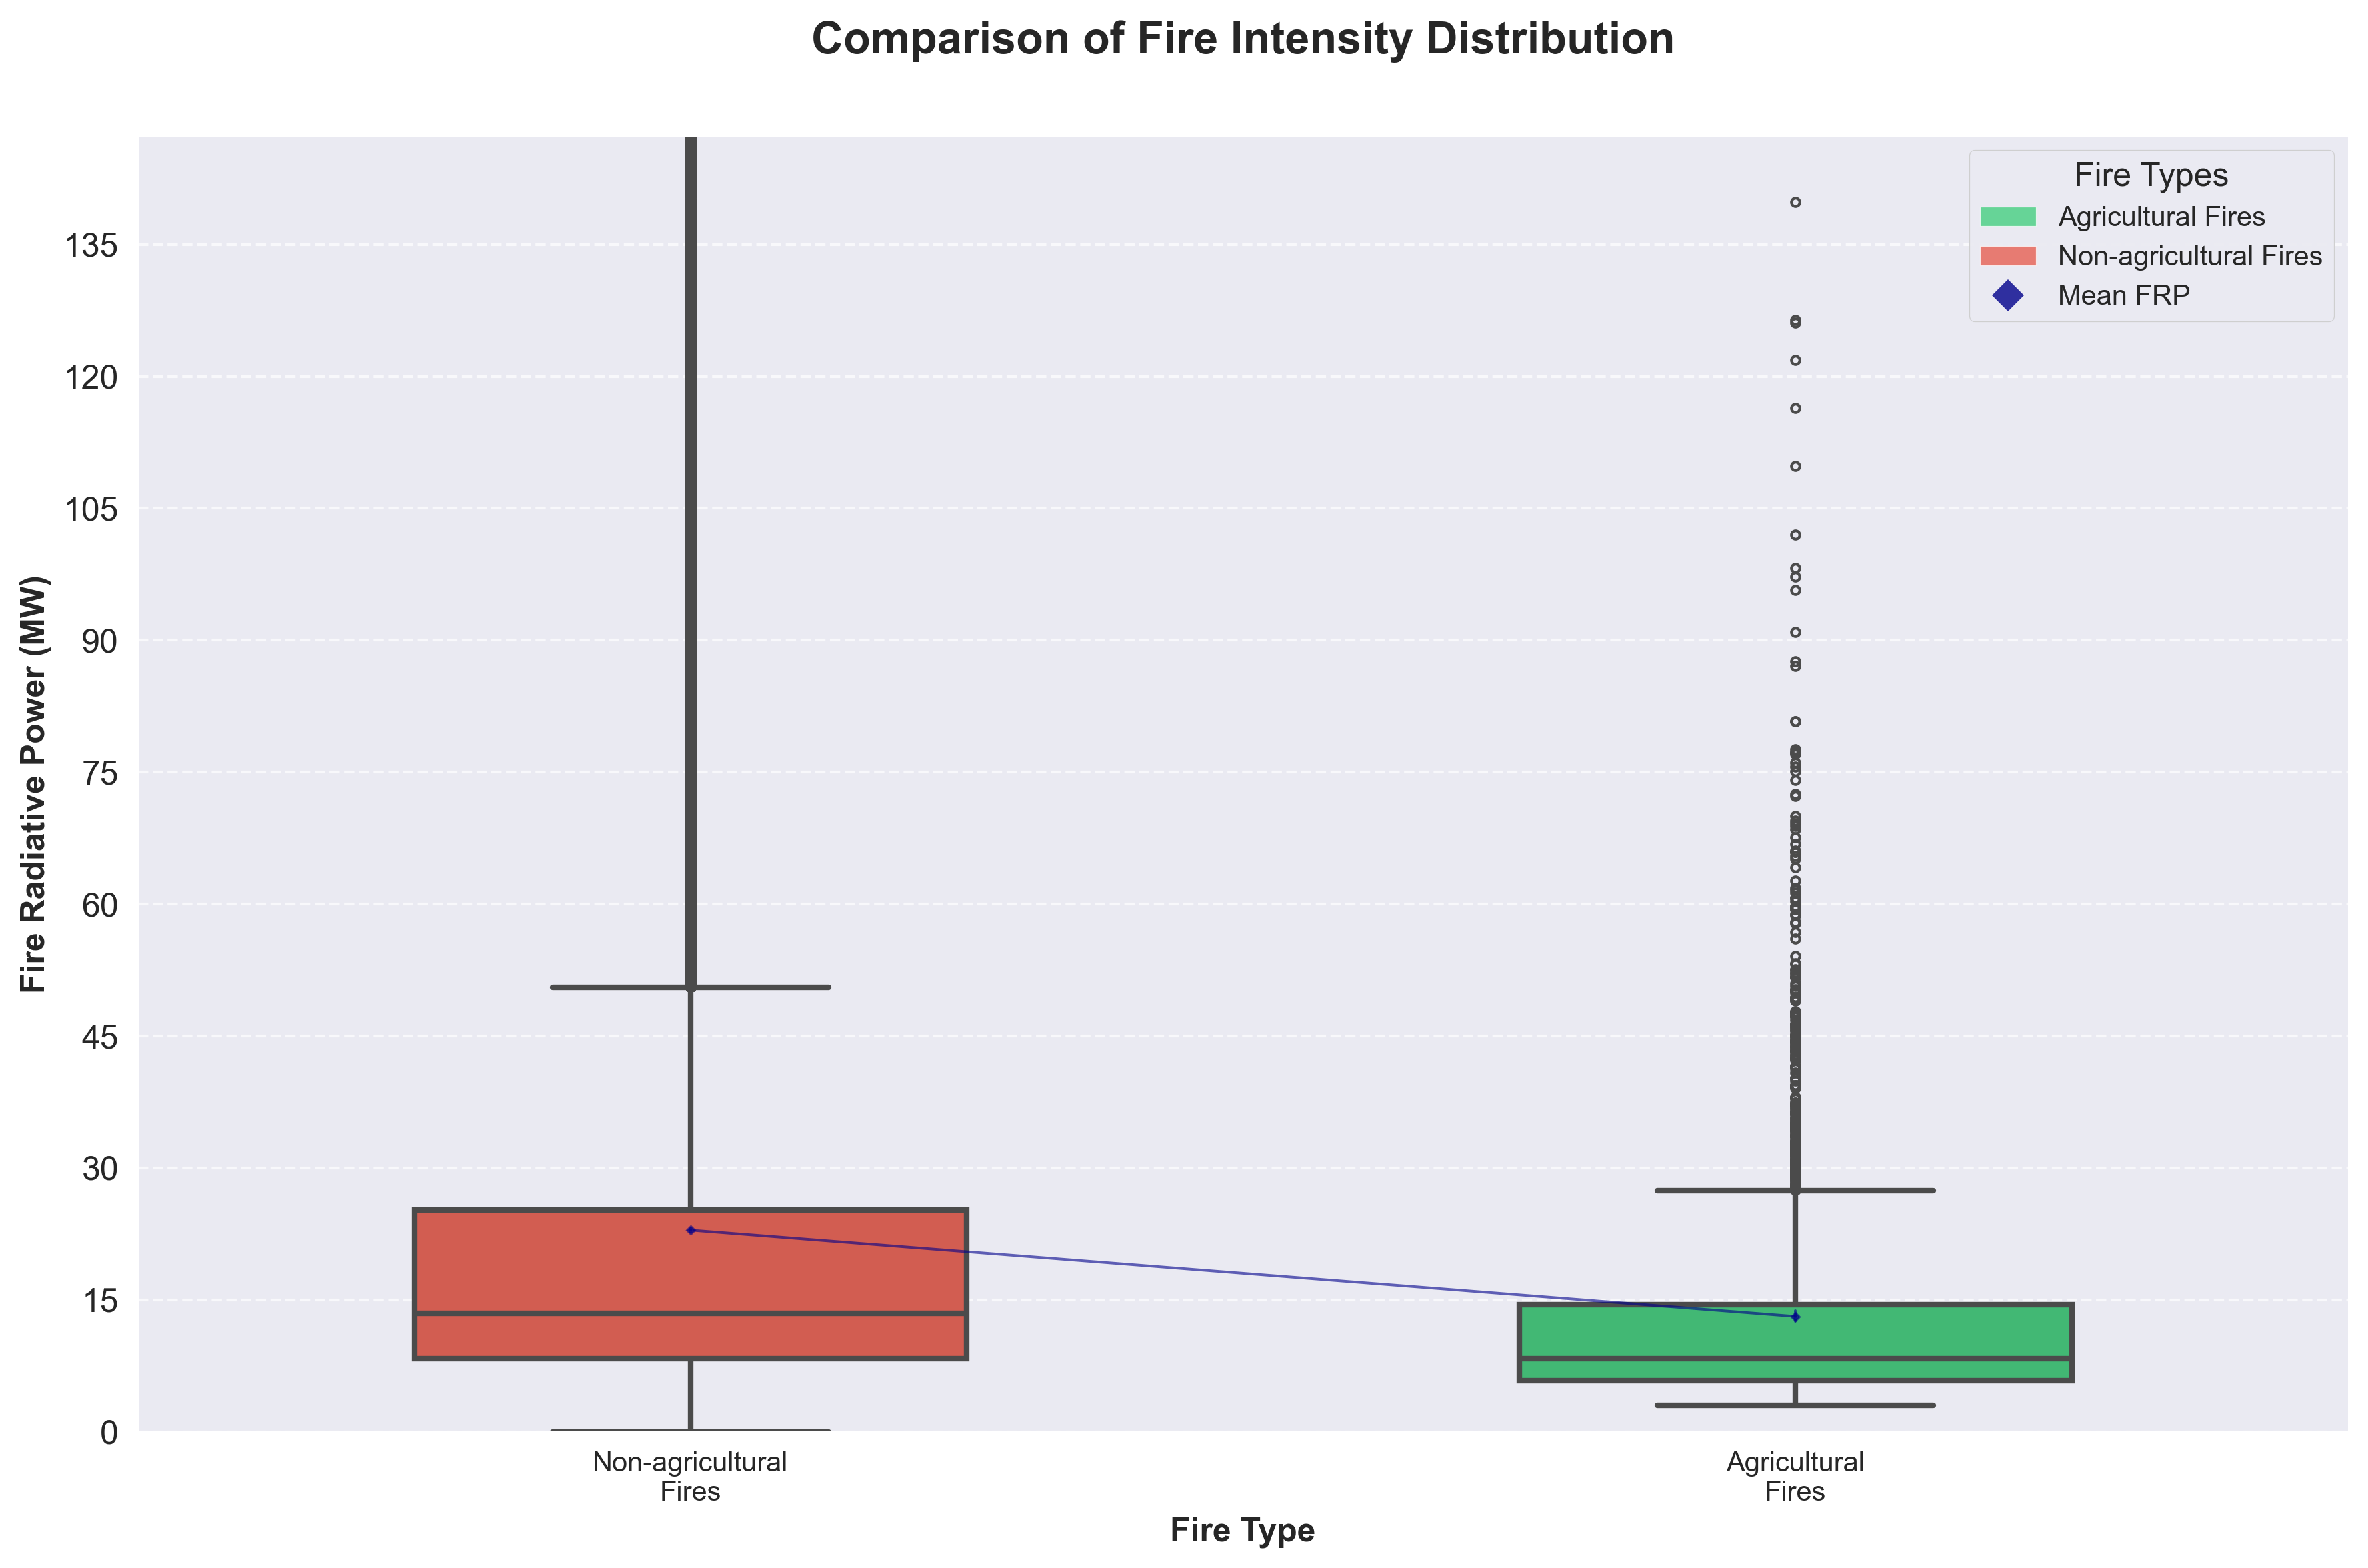

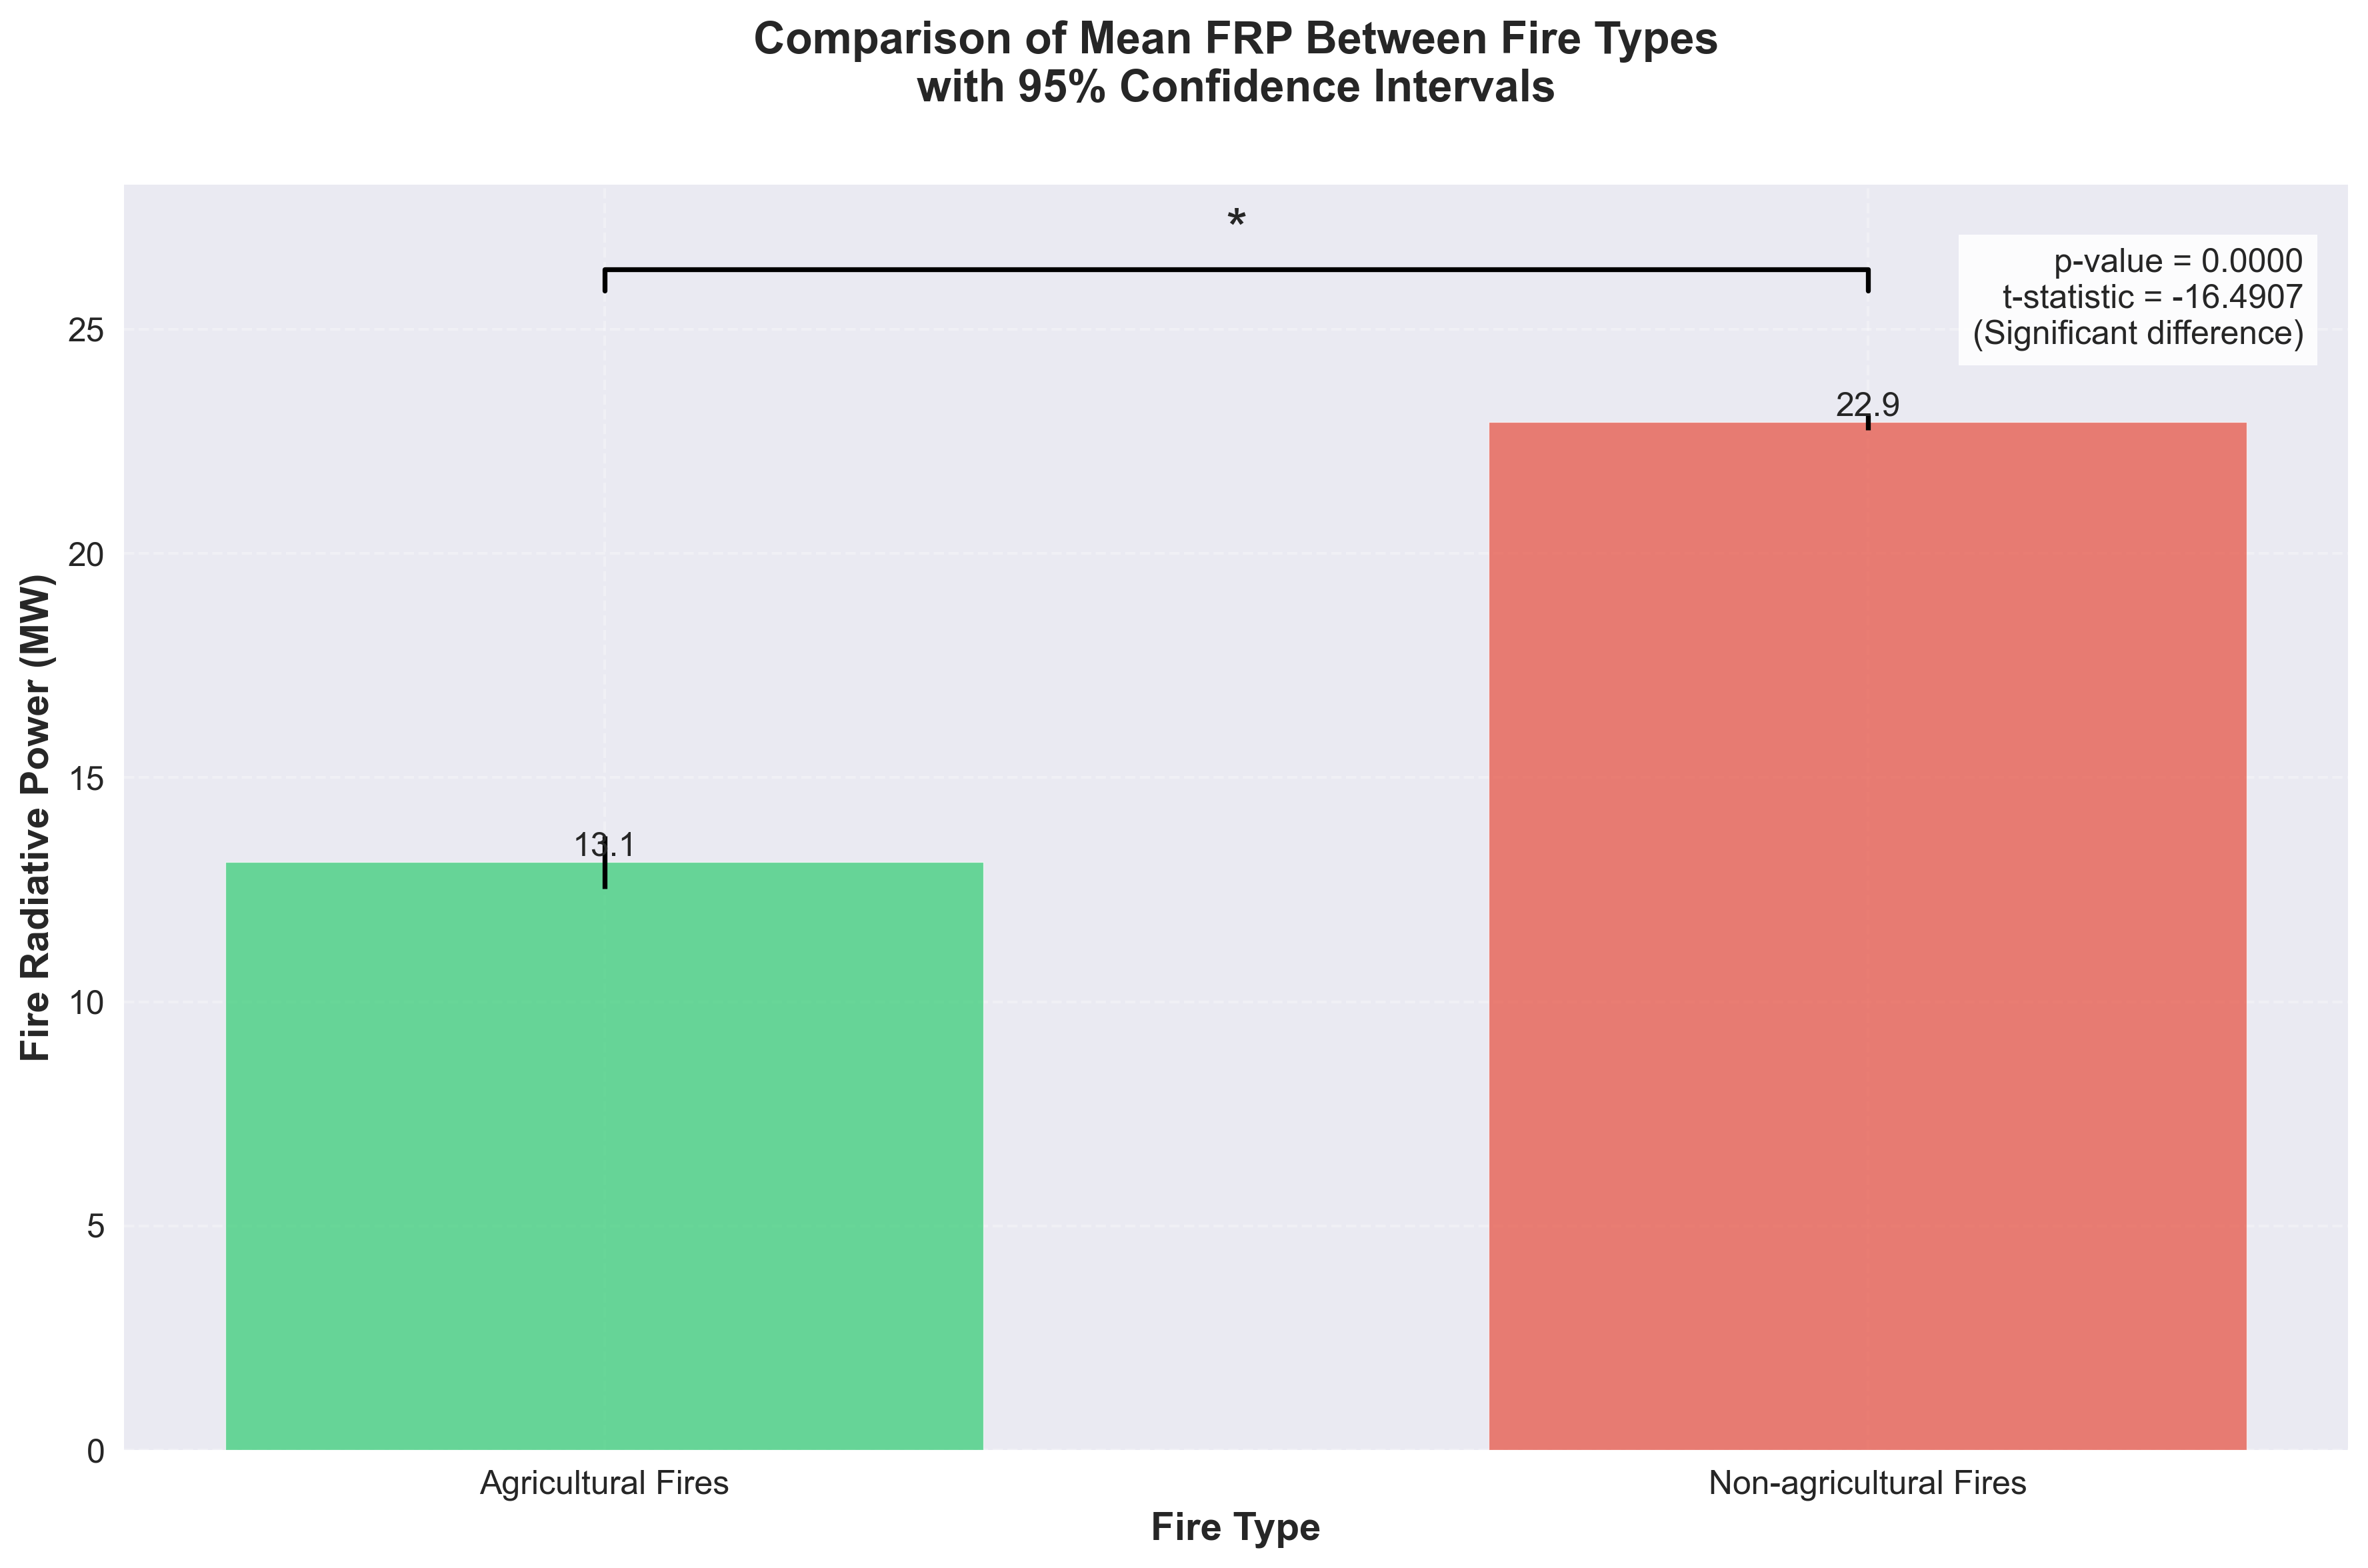

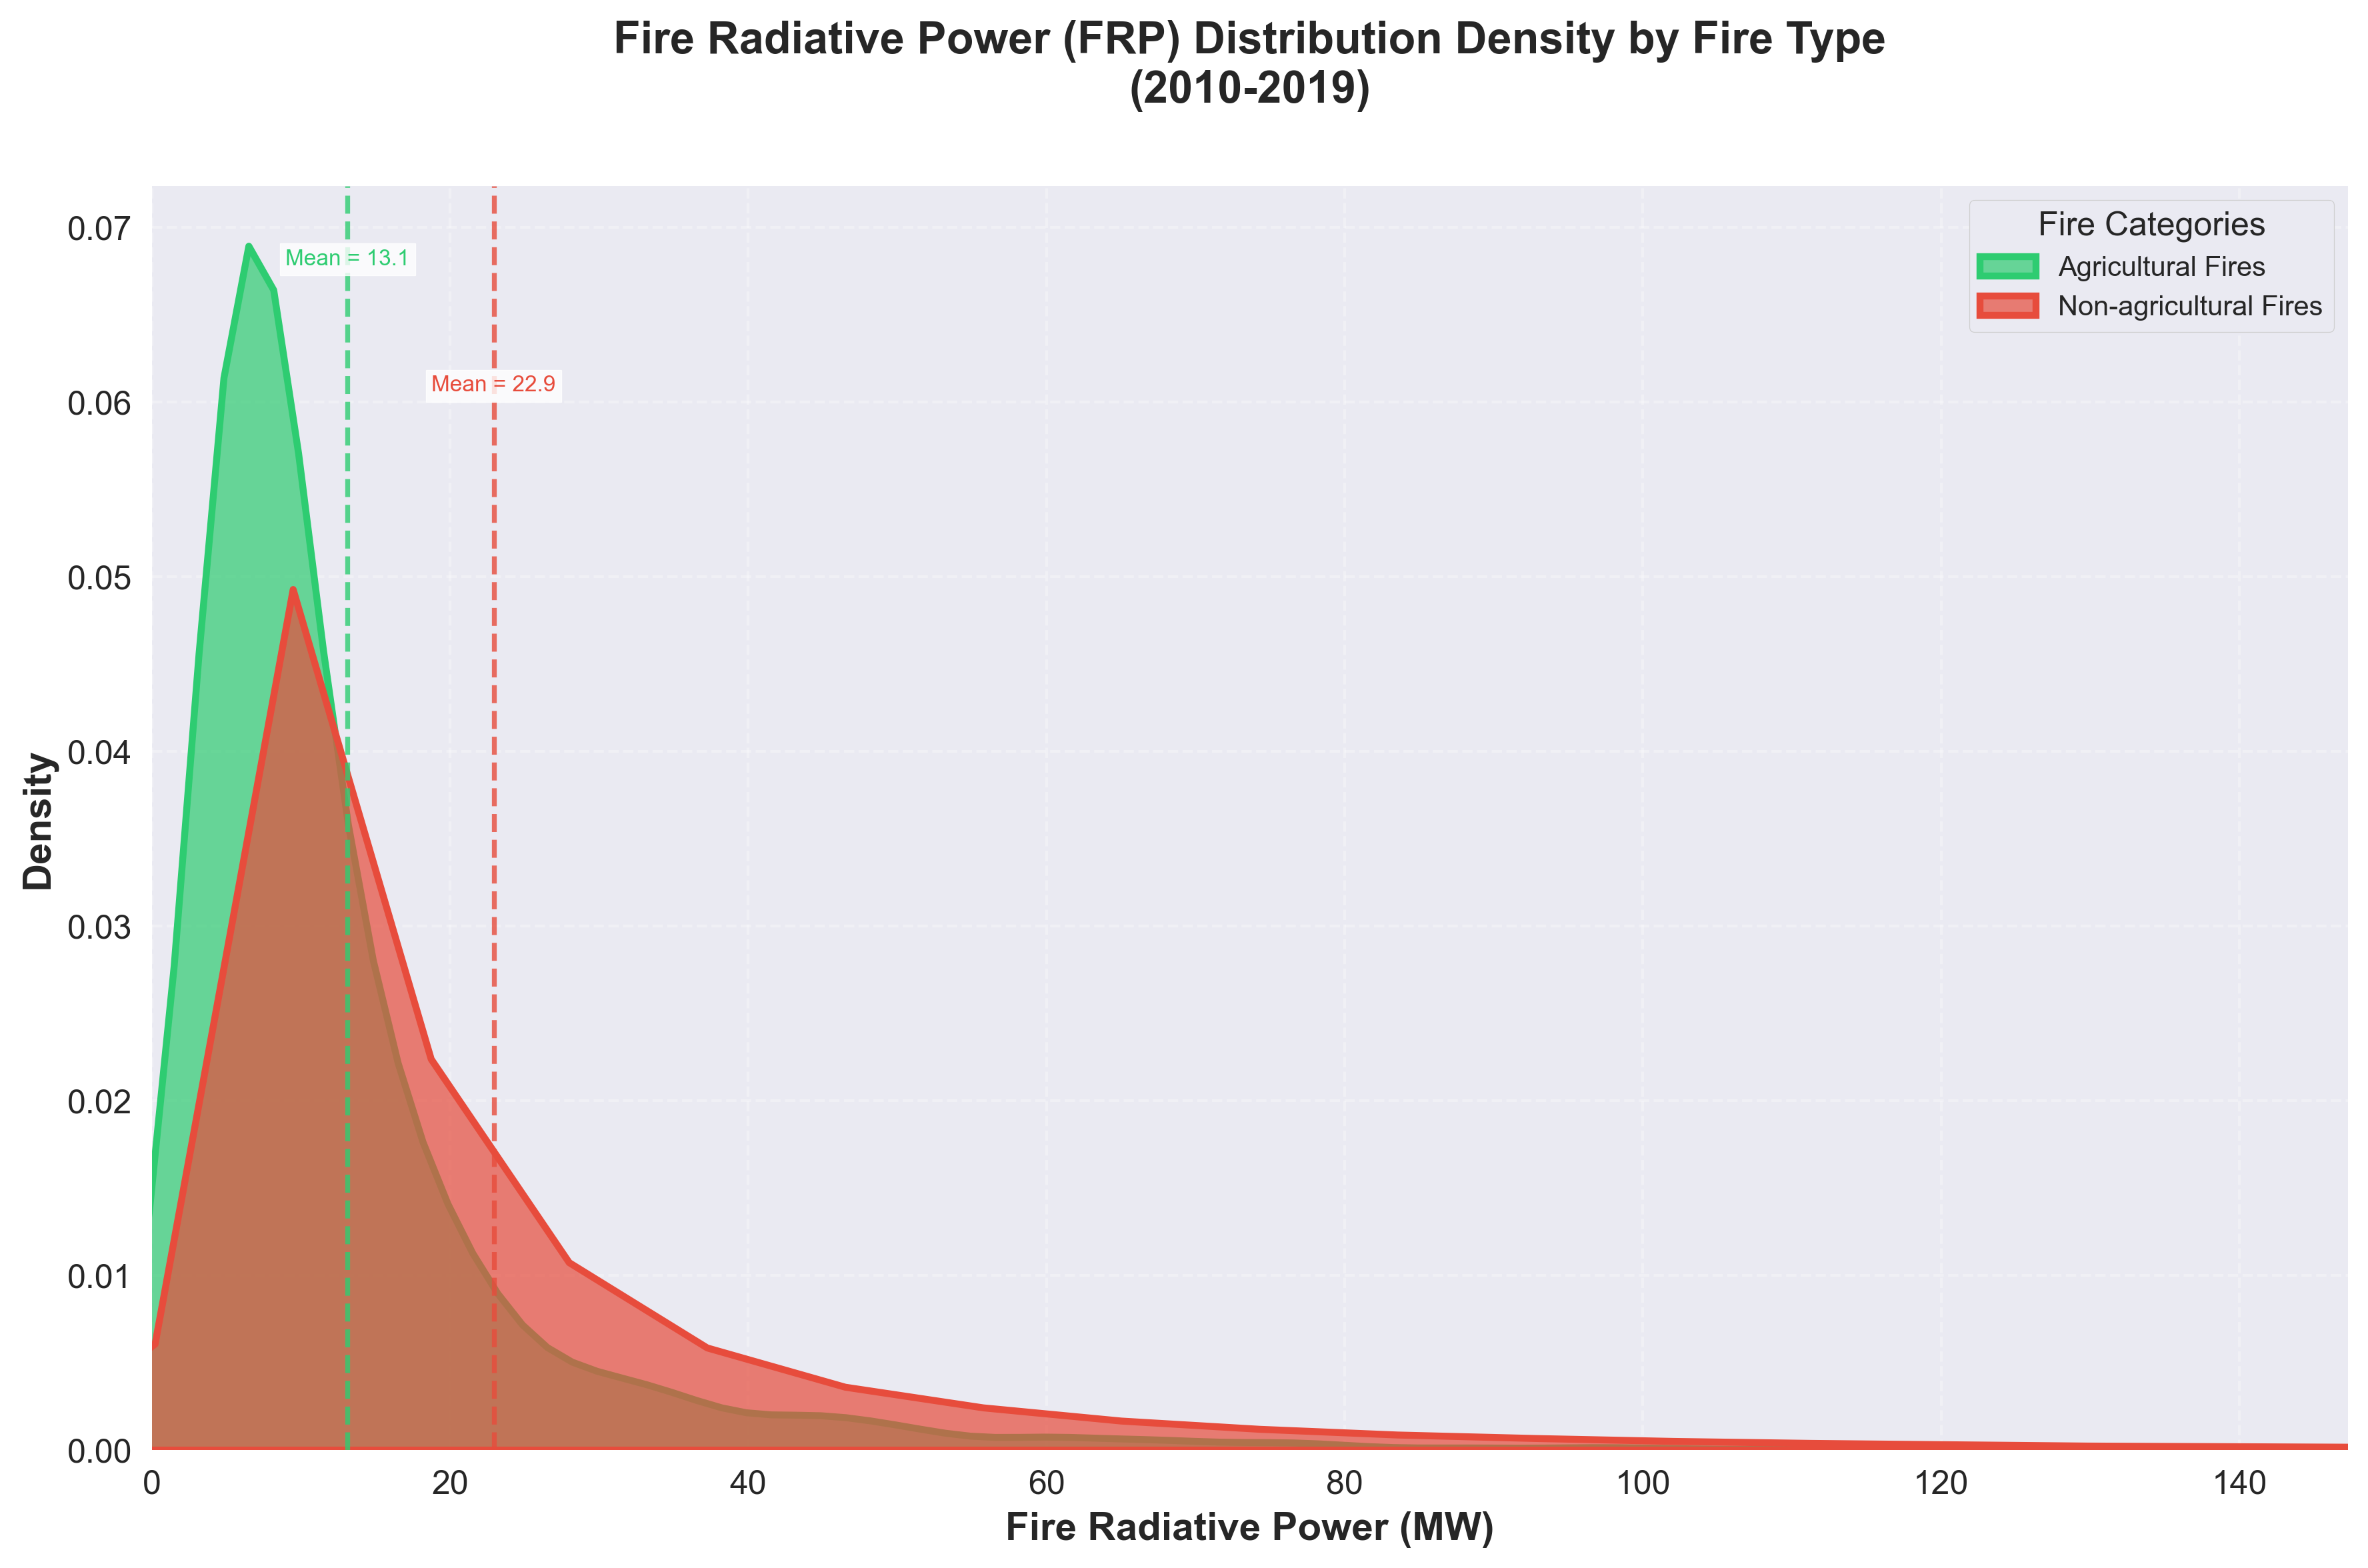

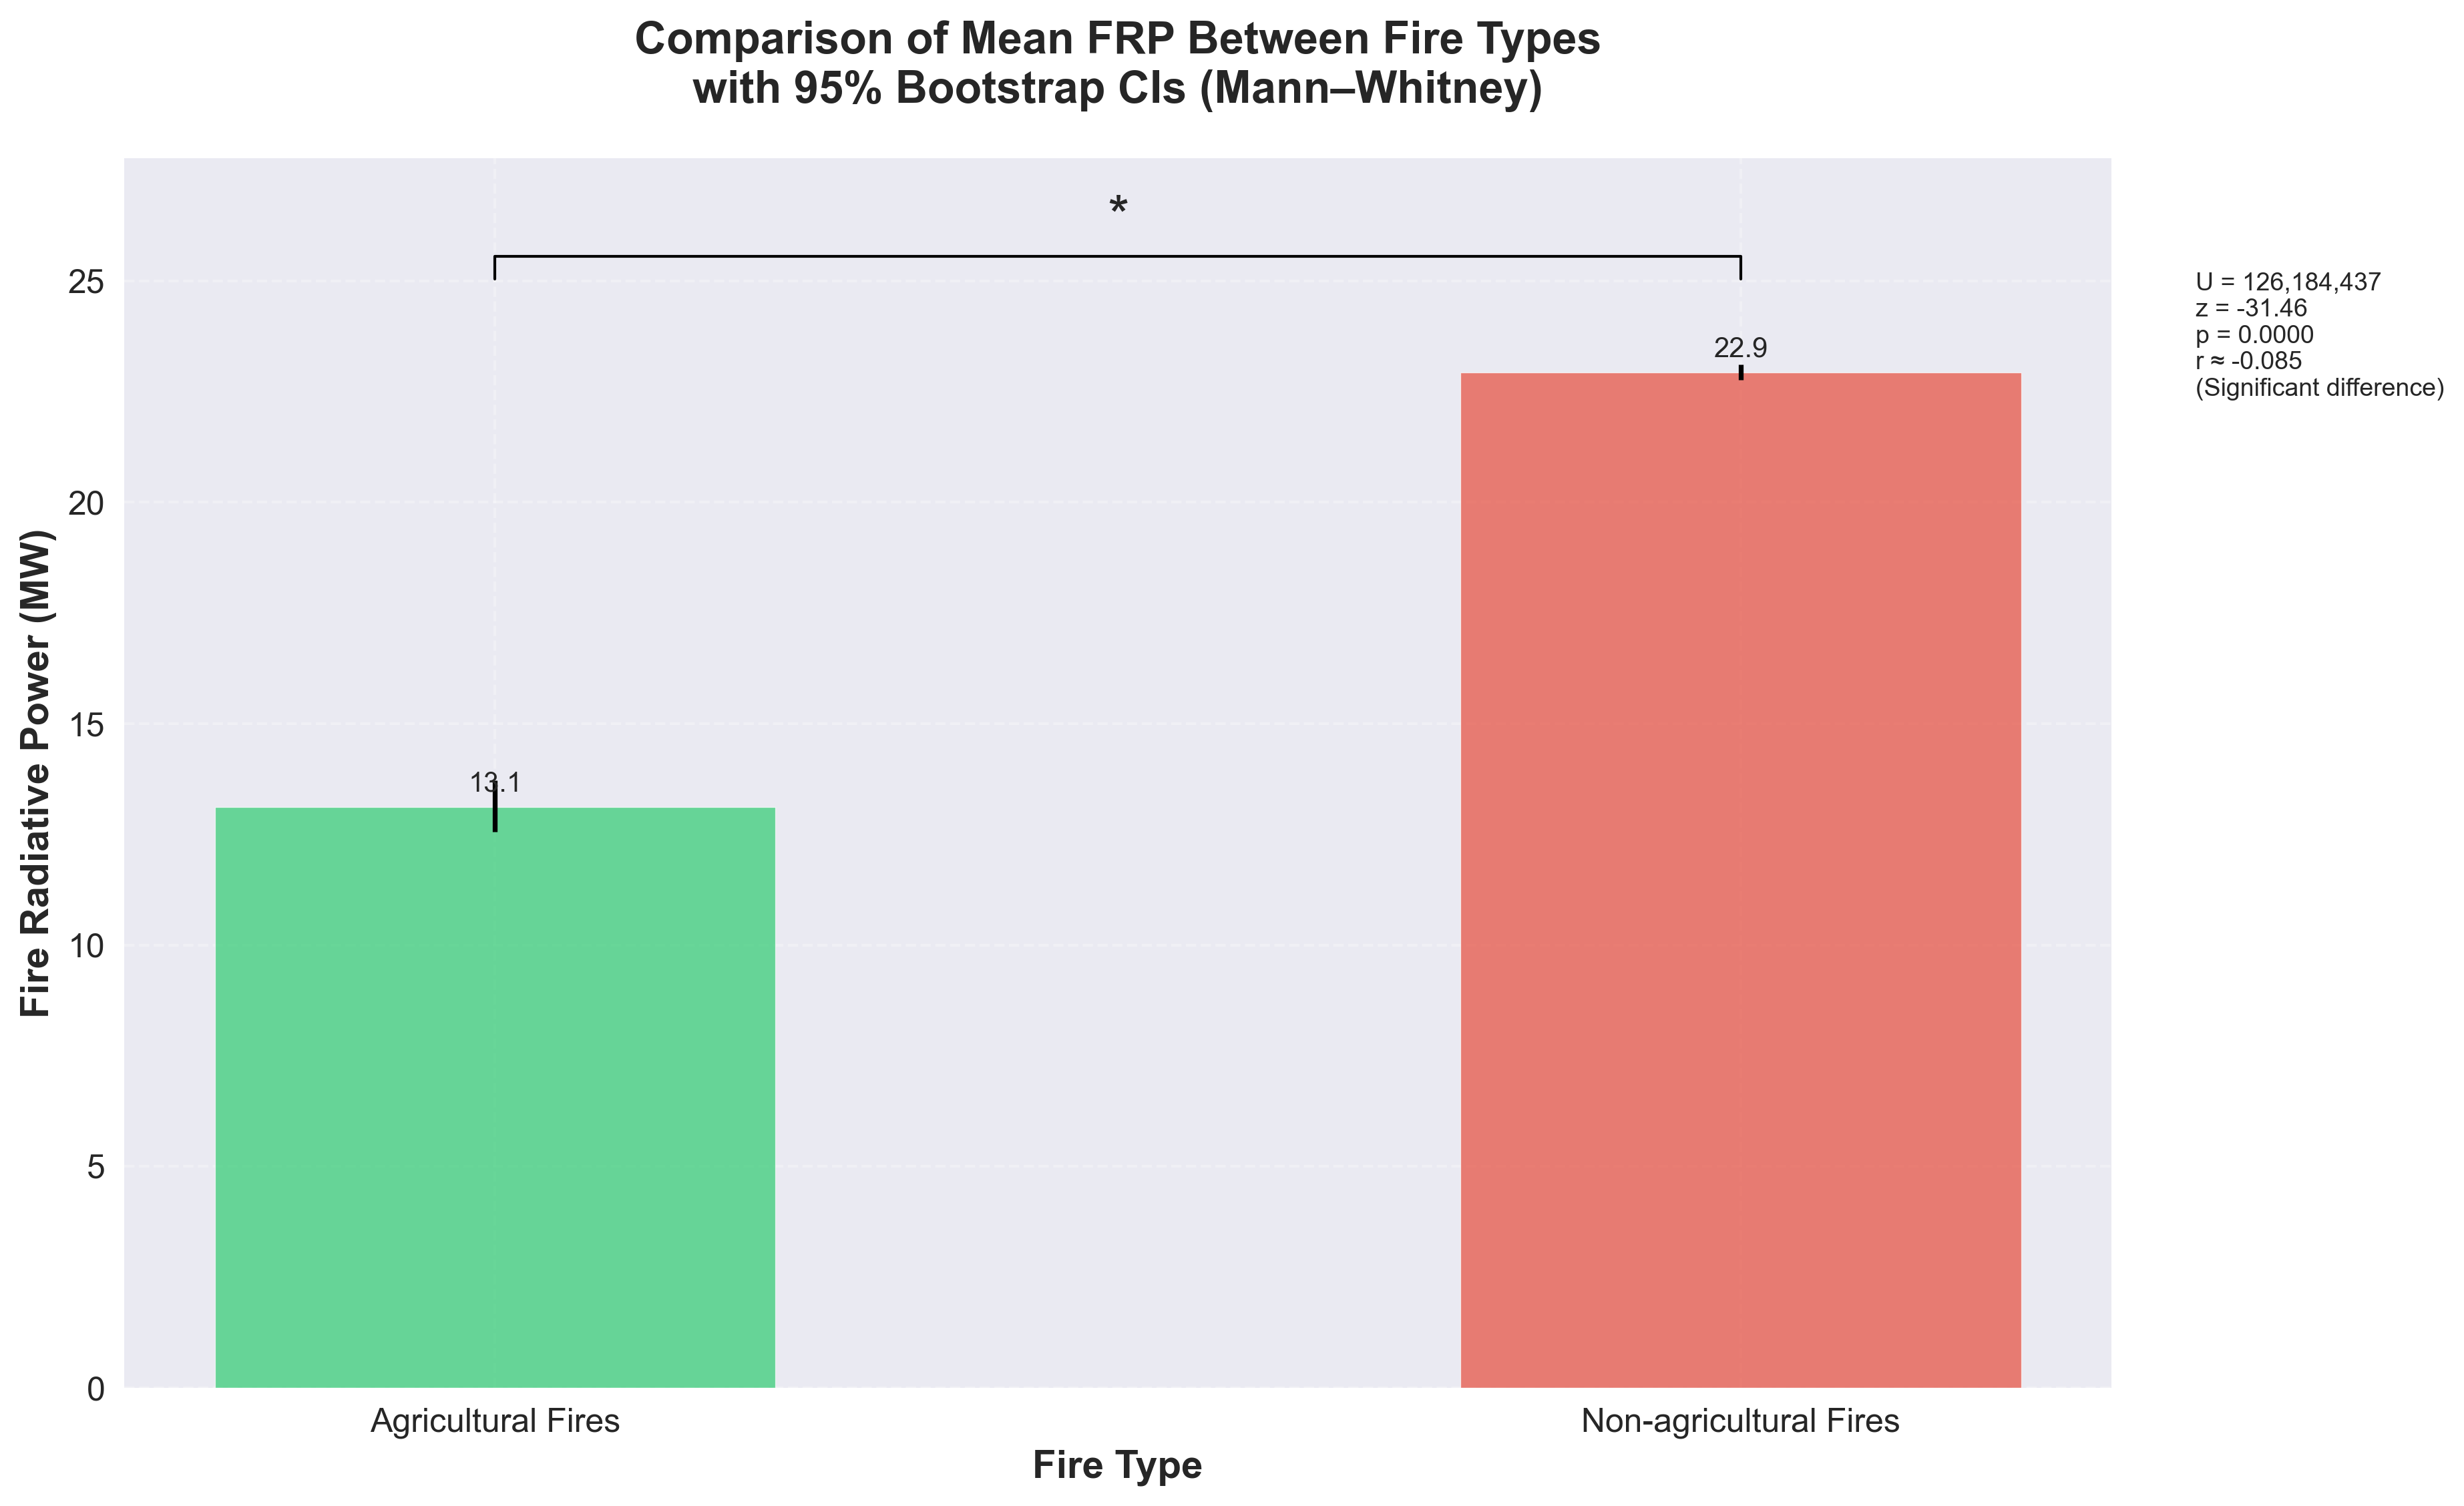


Agricultural Fires Statistics:
count    2890.000000
mean       13.115017
std        16.161262
min         3.000000
25%         5.800000
50%         8.300000
75%        14.475000
max       315.400000
Name: frp, dtype: float64

Non-agricultural Fires Statistics:
count    132622.000000
mean         22.926733
std          31.896455
min           0.000000
25%           8.300000
50%          13.500000
75%          25.200000
max        1824.400000
Name: frp, dtype: float64

t-test results:
t-statistic: -16.4907
p-value: 0.0000

Fire counts by type:
fire_category
Non-agricultural    132622
Agricultural          2890
Name: count, dtype: int64


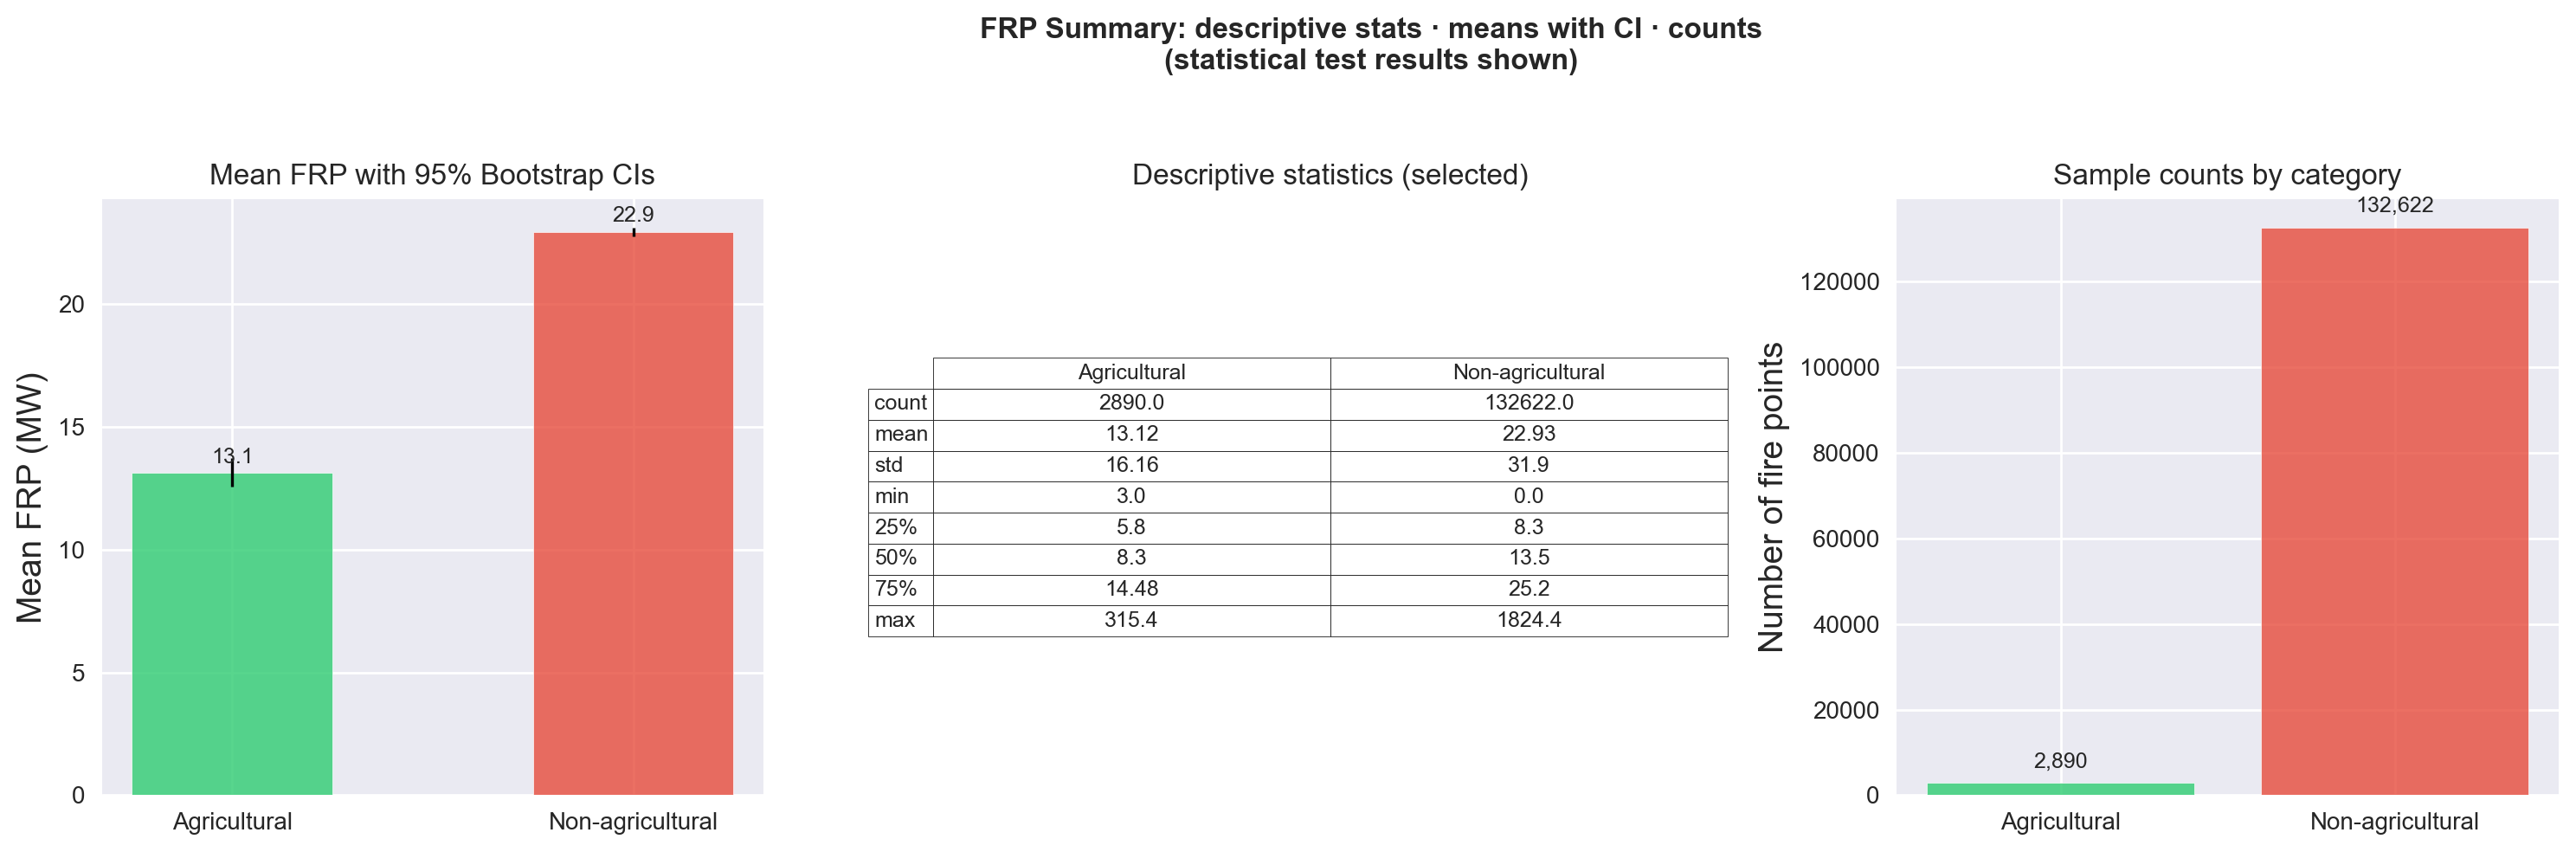

In [15]:
# Task 4 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np 
# 读取数据
df = pd.read_csv(r'C:\Users\46400\Desktop\GKG\上课\seminar 1\CNGF5020 (L01) - Environmental Modeling and Big Data Analytics\作业\Mini Project I\提交\modis_heilongjiang_classified_fires.csv')

# 创建农业火与非农业火的分类
df['fire_category'] = df['fire_type'].map(
    lambda x: 'Agricultural' if x in ['Maize_Straw_Burning', 'Wheat_Straw_Burning']
    else 'Non-agricultural' if x in ['Cropland_Fire_Other', 'Non_Cropland_Fire'] else 'Other'
)

# 基础统计分析
ag_stats = df[df['fire_category']=='Agricultural']['frp'].describe()
non_ag_stats = df[df['fire_category']=='Non-agricultural']['frp'].describe()

# 设置整体风格和字体大小
plt.style.use('seaborn-v0_8')
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# 创建画布
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
colors = {'Agricultural': '#2ecc71', 'Non-agricultural': '#e74c3c'}

# 创建箱线图
box_plot = sns.boxplot(x='fire_category', y='frp', 
           data=df[df['fire_category'].isin(['Agricultural', 'Non-agricultural'])],
           palette=colors,
           width=0.5,
           linewidth=2,
           fliersize=3,  # 减小异常值点的大小
           ax=ax,
           whis=1.5)    # 设置须的长度

 # 添加均值点并调整样式 - 减小点的大小和调整透明度
point_plot = sns.pointplot(x='fire_category', y='frp', 
             data=df[df['fire_category'].isin(['Agricultural', 'Non-agricultural'])],
             color='darkblue',
             markers='D',
             scale=0.3,  # 进一步减小点的大小
             alpha=0.6,
             ax=ax,
             zorder=3)

# 调整字体大小和标签样式
plt.title('Fire Radiative Power (FRP) Distribution by Fire Type\n(2010-2019)',
         pad=20,
         fontweight='bold',
         fontsize=14)
plt.ylabel('Fire Radiative Power (MW)',
         fontweight='bold',
         fontsize=12)
plt.xlabel('Fire Type',
         fontweight='bold',
         fontsize=12)

# 调整y轴范围和刻度
y_max = df['frp'].quantile(0.99)  # 使用99分位数作为上限
ax.set_ylim(0, y_max)
ax.yaxis.set_major_locator(plt.MaxNLocator(10))  # 设置y轴主刻度数量

# 调整轴线粗细和样式
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 自定义x轴标签
plt.xticks(ticks=[0, 1],
          labels=['Non-agricultural\nFires', 'Agricultural\nFires'],
          fontsize=10)

# 调整y轴刻度标签的格式
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 添加网格线
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# 自定义图例
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors['Agricultural'], alpha=0.7, label='Agricultural Fires'),
    Patch(facecolor=colors['Non-agricultural'], alpha=0.7, label='Non-agricultural Fires'),
    plt.Line2D([0], [0], marker='D', color='darkblue', label='Mean FRP',
               markerfacecolor='darkblue', markersize=8, linestyle='None', alpha=0.8)
]
ax.legend(handles=legend_elements,
         loc='upper right',
         title='Fire Types',
         title_fontsize=12,
         fontsize=10,
         frameon=True,
         framealpha=0.9)

# 添加描述性文本

plt.title('Comparison of Fire Intensity Distribution',
          pad=30,  # 增加标题的上边距
          fontweight='bold')

# 调整布局
plt.tight_layout()

# 保存图像
plt.savefig('frp_distribution_comparison2.png', dpi=300, bbox_inches='tight')

# 显示图像
plt.show()

# 进行独立样本t检验
ag_frp = df[df['fire_category']=='Agricultural']['frp']
non_ag_frp = df[df['fire_category']=='Non-agricultural']['frp']
t_stat, p_value = stats.ttest_ind(ag_frp, non_ag_frp)

# 创建t检验结果可视化
plt.figure(figsize=(12, 8), dpi=300)

# 设置风格
plt.style.use('seaborn-v0_8')
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# 计算均值和置信区间
def mean_confidence_interval(data, confidence=0.95):
    from scipy import stats
    mean = np.mean(data)
    se = stats.sem(data)
    ci = se * stats.t.ppf((1 + confidence) / 2, len(data)-1)
    return mean, ci

# 计算两组数据的均值和置信区间
ag_mean, ag_ci = mean_confidence_interval(ag_frp)
non_ag_mean, non_ag_ci = mean_confidence_interval(non_ag_frp)

# 绘制条形图
categories = ['Agricultural Fires', 'Non-agricultural Fires']
means = [ag_mean, non_ag_mean]
cis = [ag_ci, non_ag_ci]

bars = plt.bar(categories, means, 
        color=['#2ecc71', '#e74c3c'],
        alpha=0.7,
        width=0.6)

# 添加误差线
plt.errorbar(categories, means, yerr=cis, 
             fmt='none', color='black', capsize=5)

# 添加均值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

# 添加p值标注 - 使用轴的相对坐标（0-1），不要用 data 高度乘坐标
max_height = max(means) + max(cis)
p_value_text = f'p-value = {p_value:.4f}\nt-statistic = {t_stat:.4f}'
if p_value < 0.05:
    p_value_text += '\n(Significant difference)'
ax = plt.gca()
# 放在图的右上角（轴坐标），并保证不会被标题遮挡
ax.text(0.98, 0.95, p_value_text,
        ha='right',
        va='top',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=5))

# 设置标题和标签
plt.title('Comparison of Mean FRP Between Fire Types\nwith 95% Confidence Intervals',
          pad=30,  # 增加标题的上边距
          fontweight='bold')
plt.ylabel('Fire Radiative Power (MW)', fontweight='bold')
plt.xlabel('Fire Type', fontweight='bold')

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.3)

# 调整y轴范围
plt.ylim(0, max_height*1.2)

# 添加显著性标记（如果p值显著）
if p_value < 0.05:
    y = max(means) + max(cis)
    x1, x2 = 0, 1
    plt.plot([x1, x1, x2, x2], [y*1.1, y*1.12, y*1.12, y*1.1], color='black')
    plt.text((x1+x2)/2, y*1.13, '*', ha='center', va='bottom', fontsize=20)

plt.tight_layout()

# 保存图像
plt.savefig('frp_ttest_comparison2.png', dpi=300, bbox_inches='tight')

# 显示图像
plt.show()


# 创建密度图
plt.figure(figsize=(12, 8), dpi=300)

# 设置风格
plt.style.use('seaborn-v0_8')
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# 绘制密度曲线
sns.kdeplot(data=df[df['fire_category']=='Agricultural'], 
            x='frp', 
            label='Agricultural Fires',
            color='#2ecc71',
            linewidth=2.5,
            alpha=0.7,
            fill=True)

sns.kdeplot(data=df[df['fire_category']=='Non-agricultural'], 
            x='frp', 
            label='Non-agricultural Fires',
            color='#e74c3c',
            linewidth=2.5,
            alpha=0.7,
            fill=True)

# 设置标题和标签
plt.title('Fire Radiative Power (FRP) Distribution Density by Fire Type\n(2010-2019)',
         pad=30,
         fontweight='bold')
plt.xlabel('Fire Radiative Power (MW)',
         fontweight='bold')
plt.ylabel('Density',
         fontweight='bold')

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.3)

# 自定义图例
plt.legend(title='Fire Categories',
          title_fontsize=12,
          fontsize=10,
          frameon=True,
          framealpha=0.9,
          loc='upper right')



# 设置x轴范围（去除极端值）
x_max = df['frp'].quantile(0.99)  # 使用99分位数作为上限
plt.xlim(0, x_max)

# 添加均值线和标注
for i, (category, color) in enumerate(zip(['Agricultural', 'Non-agricultural'], ['#2ecc71', '#e74c3c'])):
    mean_val = df[df['fire_category']==category]['frp'].mean()
    plt.axvline(x=mean_val, color=color, linestyle='--', alpha=0.8)
    # 交错放置文本标签，调整字体大小
    y_pos = plt.gca().get_ylim()[1] * (0.95 - i*0.1)  # 不同高度放置标签
    plt.text(mean_val, y_pos,
            f'Mean = {mean_val:.1f}',  # 简化文本
            color=color,
            ha='center',
            va='top',
            fontsize=8,  # 减小字体大小
            bbox=dict(facecolor='white', alpha=0.8, pad=2))  # 添加白色背景框

# 保存图像
plt.savefig('frp_density_distribution2.png', dpi=300, bbox_inches='tight')

# 显示图像
plt.tight_layout()
plt.show()

from scipy.stats import mannwhitneyu
import numpy as np

# 准备数据（如果之前已有则复用）
ag_frp = df[df['fire_category']=='Agricultural']['frp'].dropna().values
non_ag_frp = df[df['fire_category']=='Non-agricultural']['frp'].dropna().values

# Mann-Whitney U 检验
u_stat, p_mw = mannwhitneyu(ag_frp, non_ag_frp, alternative='two-sided')
n1, n2 = len(ag_frp), len(non_ag_frp)
mu_u = n1 * n2 / 2
sigma_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
z = (u_stat - mu_u) / sigma_u
r_effect = z / np.sqrt(n1 + n2)  # 近似效应量 r

# Bootstrap 计算均值的 95% CI（用于图形的误差条）
def bootstrap_mean_ci(x, n_boot=5000, ci=95, seed=0):
    rng = np.random.default_rng(seed)
    boots = []
    for _ in range(n_boot):
        bx = rng.choice(x, size=len(x), replace=True)
        boots.append(np.mean(bx))
    lo = np.percentile(boots, (100-ci)/2)
    hi = np.percentile(boots, 100-(100-ci)/2)
    return np.mean(x), (np.mean(x)-lo, hi-np.mean(x))  # 返回 mean 和 (lower_err, upper_err)

ag_mean, ag_err = bootstrap_mean_ci(ag_frp)
non_mean, non_err = bootstrap_mean_ci(non_ag_frp)

# 绘图：均值条形图 + 非对称误差条（bootstrap）
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)  # 使用 fig, ax 便于放置注释在图外
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size':12, 'axes.labelsize':14, 'axes.titlesize':16})

categories = ['Agricultural Fires', 'Non-agricultural Fires']
means = [ag_mean, non_mean]
# 将误差转换为 yerr 格式 (2 x N) 矩阵
yerr = np.array([[ag_err[0], non_err[0]], [ag_err[1], non_err[1]]])

# 缩小柱子宽度以避免与注释或边框重叠
bars = ax.bar(categories, means,
               color=['#2ecc71', '#e74c3c'],
               alpha=0.7, width=0.45)

# 添加误差线（上下不同）
for i, bar in enumerate(bars):
    lower = yerr[0, i]
    upper = yerr[1, i]
    ax.errorbar(bar.get_x() + bar.get_width()/2., bar.get_height(),
                 yerr=np.array([[lower], [upper]]),
                 fmt='none', color='black', capsize=5)

# 均值标签（略微上移避免与误差线重合）
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01 * max(means),
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

# 调整 y 轴上限为数据顶部留出空间（避免与注释/星号冲突）
top_margin = max(means) + max(yerr[1, :]) * 2.0
ax.set_ylim(0, top_margin * 1.15)

# p值/统计量注释 - 放到图右侧外部（使用 figure 坐标），字体稍小以免遮挡
stats_text = f"U = {int(u_stat):,}\nz = {z:.2f}\np = {p_mw:.4f}\nr ≈ {r_effect:.3f}"
if p_mw < 0.05:
    stats_text += '\n(Significant difference)'
fig = plt.gcf()
fig.text(0.92, 0.78, stats_text, ha='left', va='top',
         fontsize=9,
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=6))

# 若显著，添加星号标记并绘制连线（位置依据轴数据而非绝对高度）
if p_mw < 0.05:
    # 在两柱上方画连线并放置星号，y_line 使用当前轴上限的比例定位
    y_line = ax.get_ylim()[1] * 0.92
    x1, x2 = bars[0].get_x() + bars[0].get_width()/2., bars[1].get_x() + bars[1].get_width()/2.
    ax.plot([x1, x1, x2, x2], [y_line*0.98, y_line, y_line, y_line*0.98], color='black', linewidth=1.0)
    ax.text((x1+x2)/2, y_line*1.01, '*', ha='center', va='bottom', fontsize=20)

# 标题与标签
ax.set_title('Comparison of Mean FRP Between Fire Types\nwith 95% Bootstrap CIs (Mann–Whitney)', pad=20, fontweight='bold')
ax.set_ylabel('Fire Radiative Power (MW)', fontweight='bold')
ax.set_xlabel('Fire Type', fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.3)

# 留出右侧空间给注释并保存
plt.tight_layout(rect=[0, 0, 0.9, 0.96])
plt.savefig('frp_mannwhitney_comparison2.png', dpi=300, bbox_inches='tight')
plt.show()



# 输出统计结果
print("\nAgricultural Fires Statistics:")
print(ag_stats)
print("\nNon-agricultural Fires Statistics:")
print(non_ag_stats)
print("\nt-test results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# 计算每种类型的火点数量
fire_counts = df['fire_category'].value_counts()
print("\nFire counts by type:")
print(fire_counts)

# 图表展示：均值+CI、描述性统计表格、以及样本计数
import pandas as pd

# 准备描述性统计表（使用 describe 结果）
summary = pd.DataFrame({
    'Agricultural': ag_stats[['count','mean','std','min','25%','50%','75%','max']],
    'Non-agricultural': non_ag_stats[['count','mean','std','min','25%','50%','75%','max']]
})
summary.index = ['count','mean','std','min','25%','50%','75%','max']

# 准备均值与 bootstrap CI（之前计算得到 ag_mean, ag_err, non_mean, non_err）
means = [ag_mean, non_mean]
lower_err = [ag_err[0], non_err[0]]
upper_err = [ag_err[1], non_err[1]]

# 计数（保证顺序）
counts = fire_counts.reindex(['Agricultural','Non-agricultural']).fillna(0).astype(int)
count_labels = ['Agricultural','Non-agricultural']

# 绘图：1x3 面板
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=200, gridspec_kw={'width_ratios':[1,1.2,1]})
plt.style.use('seaborn-v0_8')

# 左：均值条形 + 非对称 bootstrap CI
ax = axes[0]
bar_positions = range(len(means))
bars = ax.bar(bar_positions, means, color=['#2ecc71','#e74c3c'], width=0.5, alpha=0.8)
# 非对称误差条
for i,b in enumerate(bars):
    ax.errorbar(b.get_x() + b.get_width()/2., b.get_height(),
                yerr=np.array([[lower_err[i]],[upper_err[i]]]),
                fmt='none', ecolor='black', capsize=6, elinewidth=1.2)
    ax.text(b.get_x() + b.get_width()/2., b.get_height() + 0.01*max(means),
            f'{means[i]:.1f}', ha='center', va='bottom', fontsize=9)
ax.set_xticks(bar_positions)
ax.set_xticklabels(['Agricultural','Non-agricultural'], rotation=0)
ax.set_ylabel('Mean FRP (MW)')
ax.set_title('Mean FRP with 95% Bootstrap CIs')

# 中：描述性统计表
ax = axes[1]
ax.axis('off')
tbl = ax.table(cellText=summary.round(2).values,
               colLabels=summary.columns,
               rowLabels=summary.index,
               loc='center',
               cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1, 1.2)
ax.set_title('Descriptive statistics (selected)')

# 右：样本计数柱状图
ax = axes[2]
ax.bar(count_labels, counts.values, color=['#2ecc71','#e74c3c'], alpha=0.8)
for i,v in enumerate(counts.values):
    ax.text(i, v + max(counts.values)*0.02, f'{v:,}', ha='center', va='bottom', fontsize=9)
ax.set_title('Sample counts by category')
ax.set_ylabel('Number of fire points')



plt.suptitle('FRP Summary: descriptive stats · means with CI · counts\n(statistical test results shown)', fontsize=12, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0,0,0.94,0.95])

# 保存并展示
plt.savefig('frp_stats_summary_visualization2.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
'''
===================================================================
Chanllenge 2: Analysis
===================================================================

In fire classification, we used three filtering methods: global (confidence) filtering, spatial filtering, and time window filtering to distinguish farmland fires and farmland fires caused by straw burning from other fires.

The sources of uncertainty and the potential errors they cause are as follows:
1.Accuracy and timeliness of TIF farmland maps
The definition of corn/wheat farmland relies solely on two files: Heilongjiang_Maize_MA_2010-2019.TIF and Heilongjiang_Wheat_MA_2010-2019.TIF. Inaccurate maps, such as incorrectly identifying grassland as cornfields, can lead to an increased proportion of cornfields in the classification. TIF maps may also fail to capture farmers' crop rotation. If a farmer planted corn this year, but the TIF map still shows last year's soybeans (not corn/wheat), then the fire would be classified as a Non-Cropland Fire.

2.MODIS resolution is incompatible with farmland maps.
MODIS fire points are not precise points; they are 1km * 1km pixels. TIF farmland maps, on the other hand, may have a higher resolution of 0.5km * 0.5km. This can lead to false negatives: A real straw burn (on farmland) might occur at the edge of a 1km MODIS pixel, but the center coordinates of that pixel might fall on an adjacent road or woodland, causing the classifier to incorrectly label it as Non_Cropland_Fire. False positives: A forest fire might occur next to farmland, with the center of its MODIS fire point pixel falling precisely on a TIF farmland pixel. Classifier will incorrectly label it as Cropland_Fire.

3.The burning time should be determined according to the harvest cycle.
We used a fixed time window of [mature DOY - 15, mature DOY + 30] to determine when farmers burned straw . However, farmers' burning behavior is influenced by various factors (weather, policy, labor). A real straw burning event might be delayed due to rain or government bans, occurring at (DOY + 35). The classifier would incorrectly classify the fire as Cropland_Fire_Other because it occurred outside the window.

4.Inaccurate MODIS data
MODIS data itself can be affected by clouds or dense smoke. During large-scale burning, the resulting smoke may obscure fires in other locations, or clouds may obscure the sensor's observation of the ground. This is not a random error, but a systematic one. If a county is undergoing large-scale burning (producing smoke), or burning occurs after prolonged rainy weather (producing clouds), the true number of fire points will be underestimated. The true number of fire points can also be overestimated. Industrial activities, such as chimneys of large metallurgical plants, brick kilns, or hot spring/volcanic activity exposed under specific weather conditions (although uncommon in Heilongjiang), can be misidentified as fire points by MODIS sensors. These hotspots are permanent and unrelated to agricultural activities. If these permanent industrial hotspots are located on or near agricultural TIFs, they may be incorrectly identified as Non_Cropland_Fire or even Cropland_Fire_Other, resulting in the final estimate including a very small amount of industrial pollution.



Therefore, we propose using soil moisture data to improve classification accuracy. The core logic is as follows: Straw burning is a deliberate, planned fire aimed at removing dried crop residue. Therefore, it almost always occurs when the surface and topsoil are dry. High soil moisture (e.g., immediately after rain or during irrigation) inhibits straw burning. Low soil moisture (e.g., after harvest, in sunny, dry weather) is a necessary condition for straw burning.
We plan to use daily soil moisture data that matches the resolution of the farmland map, and process it as follows:
1.Calculate the monthly average soil moisture for each TIF pixel between 2010 and 2019. Then, for each fire, calculate its SM anomaly = (daily SM value) - (monthly average SM value). A negative anomaly indicates drier conditions than usual (suitable for incineration); a positive anomaly indicates wetter conditions than usual (unsuitable for incineration). An extreme negative anomaly value is set, such as SM anomaly < -0.08.

2.The data in the three parts—Non_Cropland_Fire, Maize/Wheat_Straw_Burning, and Cropland_Fire_Other—are processed separately.
1)Extract the SM outlier value when Non_Cropland_Fire occurs.
If SM is negative (dry): This could be a false negative due to spatial mismatch (1km pixel issue). It can be reclassified as Probable_Straw_Burning (Spatial_Error).
If the SM anomaly is extremely negative (e.g., at historically drought levels): this strongly indicates a wildfire .
If the SM anomaly is positive (damp): This is unlikely to be caused by straw burning or wildfire. It could be due to an industrial heat source or data noise.
2)Extract the SM outlier value when Maize/Wheat_Straw_Burning occurs.
If the SM anomaly is negative (dry): Physical conditions are consistent with spatiotemporal evidence. The classification is confirmed as Confirmed_Straw_Burning.
If the SM anomaly is positive (humid): The physical conditions contradict the spatiotemporal evidence. This could mean that the TIF data or time window is incorrect, or that this was a fire under anomalous (humid) conditions. It can be downgraded to Anomaly_Cropland_Fire.
3)Extract the SM outlier value when Cropland_Fire_Other occurs.
If the SM error is negative (dry): This is very likely a genuine straw burning incident, delayed due to weather or other reasons, causing it to miss the fixed time window. It can be escalated to Probable_Straw_Burning (Time_Window_Error).
If the SM anomaly is positive (wet): This confirms that it is unlikely to be straw burning (e.g., it could be other types of agricultural waste being burned in wet weather). The classification remains Cropland_Fire_Other.

3.new estimate will be the sum of (Confirmed_Straw_Burning + Probable_Straw_Burning (Time_Window_Error) + Probable_Straw_Burning (Spatial_Error)).



In [ ]:
'''

===================================================================
Chanllenge 3
===================================================================

How Meteorology Influences Detection & Impact
Meteorological conditions are a critical confounding variable. They directly influence both the satellite's ability to detect fires (Detection) and the severity of the fire's environmental damage (Impact).

Proposed Methodology: Linking Fire Events to PM2.5 Data
To statistically link straw burning events to air pollution, a two-step cross-analysis is used.

Method 1: Time-Series Lagged Correlation
This method verifies the temporal relationship between fires and pollution.
1. Plot Series 1: Hourly PM2.5/PM10 concentrations (e.g., Harbin)
2. Plot Series 2: Hourly Fire Event Count (within 100km buffer)
3. Analyze Lag: Expect time lag (3–6 hrs) between fire and PM2.5 peaks.

Method 2: Wind-Based Source Attribution
This method identifies which pollution events are caused by which fires.
1. Identify Pollution Peaks: PM2.5 > 150 µg/m³.
2. Check Upwind Source: Determine dominant wind direction (past 6 hrs).
3. Cross-Validate with Fire Map:
   - YES: Strong evidence of causation.
   - NO: Likely caused by other sources (e.g., traffic, industry).


In [ ]:
'''

===================================================================
Conclusion
===================================================================

Key Findings:
Successful Classification: We developed a robust 3-rule (Confidence, Spatial, Temporal) classifier. We quantitatively determined that true straw burning accounts for 2.13% of all high-confidence fire hotspots in Heilongjiang.

Policy-Driven Trends: We identified a clear "increase-then-decrease" trend, peaking around 2014 (likely driven by agricultural subsidies) and dropping sharply after 2017 (driven by the "Blue Sky" environmental protection plan).

Low-Intensity Profile: We statistically proved (p < 0.05) that straw burning events are significantly lower in intensity (FRP) than non-agricultural fires, answering the "numerous but low-intensity" hypothesis.

Future Work:
Model Refinement (Challenge 2): We propose an advanced model using Soil Moisture Anomaly (SMA) to correct for known errors (e.g., time window delays, spatial mismatch), leading to a more accurate final count.

Impact Analysis (Challenge 3): We plan to link our fire event data with PM2.5 and wind data (using time-lag correlation and source attribution) to quantify the precise impact of straw burning on urban air quality.
